# Apex for PyTorch users

This notebook serves as a small tutorial to introduce PyTorch users to some features of NVIDIA's apex (A Pytorch extension) mixed precision training.

Have a look at the [repo](https://github.com/NVIDIA/apex) for install instructions.

author: [ptrblck](https:github.com/ptrblck)

!work in progress!

## Mixed precision training

apex provides some tools and utilities for mixed precision training.
Before diving into these tools, let's first have a look why we would want to use mixed precision training at all and what benefits we would expect using it.

Based on the talk of Michael Carilli at the GTC Taiwan 2018, there are a some interesing benefits:
 1. 2-4x faster
 2. half the memory use
 3. just as poweful

with no architecture change.
You can find the talk [here](http://on-demand.gputechconf.com/gtc-taiwan/2018/video/STW8021.mp4).

Let's just setup the small example from the GTC talk and have a look what works just out of the box.

First, let's make sure the model is running fine in FP32.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(2809)
print('PyTorch version {}'.format(torch.__version__))

if not torch.cuda.is_available():
    print('CUDA is necessary for this notebook!')
device = 'cuda'  # change to another GPU id if necessary

PyTorch version 1.0.0.dev20181130


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy

### Simple FP32 training

In [3]:
# Create model in FP32, setup loss function and optimizer
N, D_in, D_out = 64, 1024, 512  # Mutliples of 8 to use TensorCores, in case you have a Volta GPU

x = torch.randn(N, D_in, device=device, dtype=torch.float)
y = torch.randn(N, D_out, device=device, dtype=torch.float)

model = nn.Linear(D_in, D_out).to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3)  # Set the learning rate a bit higher

In [4]:
# Train it for some iterations
fp32_losses = []
for t in range(5000):
    optimizer.zero_grad()
    
    output = model(x)
    loss = F.mse_loss(output, y)
    loss.backward()
    optimizer.step()

    fp32_losses.append(loss.item())

Iteration 0, loss 1.3128715753555298
Iteration 1, loss 1.3127050399780273
Iteration 2, loss 1.3125386238098145
Iteration 3, loss 1.312372088432312
Iteration 4, loss 1.3122056722640991
Iteration 5, loss 1.3120392560958862
Iteration 6, loss 1.3118728399276733
Iteration 7, loss 1.3117064237594604
Iteration 8, loss 1.3115400075912476
Iteration 9, loss 1.3113737106323242
Iteration 10, loss 1.3112074136734009
Iteration 11, loss 1.3110411167144775
Iteration 12, loss 1.3108748197555542
Iteration 13, loss 1.3107085227966309
Iteration 14, loss 1.310542345046997
Iteration 15, loss 1.3103761672973633
Iteration 16, loss 1.31020987033844
Iteration 17, loss 1.3100438117980957
Iteration 18, loss 1.309877634048462
Iteration 19, loss 1.3097114562988281
Iteration 20, loss 1.3095453977584839
Iteration 21, loss 1.3093793392181396
Iteration 22, loss 1.3092132806777954
Iteration 23, loss 1.3090472221374512
Iteration 24, loss 1.3088812828063965
Iteration 25, loss 1.3087152242660522
Iteration 26, loss 1.308549

Iteration 531, loss 1.2275266647338867
Iteration 532, loss 1.2273715734481812
Iteration 533, loss 1.2272164821624756
Iteration 534, loss 1.2270615100860596
Iteration 535, loss 1.2269065380096436
Iteration 536, loss 1.2267515659332275
Iteration 537, loss 1.2265965938568115
Iteration 538, loss 1.226441740989685
Iteration 539, loss 1.2262868881225586
Iteration 540, loss 1.2261319160461426
Iteration 541, loss 1.2259771823883057
Iteration 542, loss 1.2258222103118896
Iteration 543, loss 1.2256674766540527
Iteration 544, loss 1.2255125045776367
Iteration 545, loss 1.2253577709197998
Iteration 546, loss 1.2252031564712524
Iteration 547, loss 1.225048303604126
Iteration 548, loss 1.224893569946289
Iteration 549, loss 1.2247388362884521
Iteration 550, loss 1.2245842218399048
Iteration 551, loss 1.2244296073913574
Iteration 552, loss 1.22427499294281
Iteration 553, loss 1.2241203784942627
Iteration 554, loss 1.2239658832550049
Iteration 555, loss 1.223811149597168
Iteration 556, loss 1.223656654

Iteration 989, loss 1.158644437789917
Iteration 990, loss 1.1584986448287964
Iteration 991, loss 1.1583528518676758
Iteration 992, loss 1.1582069396972656
Iteration 993, loss 1.1580612659454346
Iteration 994, loss 1.1579155921936035
Iteration 995, loss 1.157769799232483
Iteration 996, loss 1.1576241254806519
Iteration 997, loss 1.1574784517288208
Iteration 998, loss 1.1573327779769897
Iteration 999, loss 1.1571871042251587
Iteration 1000, loss 1.1570414304733276
Iteration 1001, loss 1.1568958759307861
Iteration 1002, loss 1.1567503213882446
Iteration 1003, loss 1.1566046476364136
Iteration 1004, loss 1.156459093093872
Iteration 1005, loss 1.1563135385513306
Iteration 1006, loss 1.1561681032180786
Iteration 1007, loss 1.156022548675537
Iteration 1008, loss 1.1558771133422852
Iteration 1009, loss 1.1557316780090332
Iteration 1010, loss 1.1555862426757812
Iteration 1011, loss 1.1554408073425293
Iteration 1012, loss 1.155295491218567
Iteration 1013, loss 1.155150055885315
Iteration 1014, l

Iteration 1430, loss 1.096189022064209
Iteration 1431, loss 1.0960516929626465
Iteration 1432, loss 1.0959141254425049
Iteration 1433, loss 1.0957766771316528
Iteration 1434, loss 1.0956392288208008
Iteration 1435, loss 1.0955017805099487
Iteration 1436, loss 1.0953644514083862
Iteration 1437, loss 1.0952271223068237
Iteration 1438, loss 1.0950896739959717
Iteration 1439, loss 1.0949523448944092
Iteration 1440, loss 1.0948150157928467
Iteration 1441, loss 1.0946776866912842
Iteration 1442, loss 1.0945404767990112
Iteration 1443, loss 1.0944031476974487
Iteration 1444, loss 1.0942658185958862
Iteration 1445, loss 1.0941288471221924
Iteration 1446, loss 1.0939915180206299
Iteration 1447, loss 1.0938541889190674
Iteration 1448, loss 1.093717098236084
Iteration 1449, loss 1.0935800075531006
Iteration 1450, loss 1.0934427976608276
Iteration 1451, loss 1.0933057069778442
Iteration 1452, loss 1.0931686162948608
Iteration 1453, loss 1.0930315256118774
Iteration 1454, loss 1.092894434928894
Ite

Iteration 1876, loss 1.0366508960723877
Iteration 1877, loss 1.036521315574646
Iteration 1878, loss 1.0363917350769043
Iteration 1879, loss 1.0362622737884521
Iteration 1880, loss 1.0361328125
Iteration 1881, loss 1.0360032320022583
Iteration 1882, loss 1.0358738899230957
Iteration 1883, loss 1.0357444286346436
Iteration 1884, loss 1.0356148481369019
Iteration 1885, loss 1.0354855060577393
Iteration 1886, loss 1.035356044769287
Iteration 1887, loss 1.0352267026901245
Iteration 1888, loss 1.035097360610962
Iteration 1889, loss 1.0349680185317993
Iteration 1890, loss 1.0348386764526367
Iteration 1891, loss 1.0347093343734741
Iteration 1892, loss 1.0345799922943115
Iteration 1893, loss 1.034450650215149
Iteration 1894, loss 1.0343213081359863
Iteration 1895, loss 1.0341920852661133
Iteration 1896, loss 1.0340628623962402
Iteration 1897, loss 1.0339337587356567
Iteration 1898, loss 1.0338045358657837
Iteration 1899, loss 1.0336753129959106
Iteration 1900, loss 1.0335460901260376
Iteration 

Iteration 2319, loss 0.9809045791625977
Iteration 2320, loss 0.9807823896408081
Iteration 2321, loss 0.9806603193283081
Iteration 2322, loss 0.9805380702018738
Iteration 2323, loss 0.9804159998893738
Iteration 2324, loss 0.980293869972229
Iteration 2325, loss 0.980171799659729
Iteration 2326, loss 0.980049729347229
Iteration 2327, loss 0.979927659034729
Iteration 2328, loss 0.9798056483268738
Iteration 2329, loss 0.9796835780143738
Iteration 2330, loss 0.9795615673065186
Iteration 2331, loss 0.9794396162033081
Iteration 2332, loss 0.9793176054954529
Iteration 2333, loss 0.9791957139968872
Iteration 2334, loss 0.979073703289032
Iteration 2335, loss 0.9789517521858215
Iteration 2336, loss 0.9788298606872559
Iteration 2337, loss 0.9787079691886902
Iteration 2338, loss 0.9785860776901245
Iteration 2339, loss 0.9784641861915588
Iteration 2340, loss 0.9783423542976379
Iteration 2341, loss 0.9782204627990723
Iteration 2342, loss 0.9780987501144409
Iteration 2343, loss 0.97797691822052
Iterati

Iteration 2828, loss 0.920762300491333
Iteration 2829, loss 0.9206479787826538
Iteration 2830, loss 0.9205338358879089
Iteration 2831, loss 0.9204195737838745
Iteration 2832, loss 0.9203054904937744
Iteration 2833, loss 0.92019122838974
Iteration 2834, loss 0.9200770854949951
Iteration 2835, loss 0.919963002204895
Iteration 2836, loss 0.9198489189147949
Iteration 2837, loss 0.9197347164154053
Iteration 2838, loss 0.9196206331253052
Iteration 2839, loss 0.9195066094398499
Iteration 2840, loss 0.9193925857543945
Iteration 2841, loss 0.9192785024642944
Iteration 2842, loss 0.9191645383834839
Iteration 2843, loss 0.9190505743026733
Iteration 2844, loss 0.9189364910125732
Iteration 2845, loss 0.9188224673271179
Iteration 2846, loss 0.9187085628509521
Iteration 2847, loss 0.9185945987701416
Iteration 2848, loss 0.918480634689331
Iteration 2849, loss 0.9183666706085205
Iteration 2850, loss 0.9182528257369995
Iteration 2851, loss 0.9181389212608337
Iteration 2852, loss 0.9180250763893127
Itera

Iteration 3390, loss 0.858883798122406
Iteration 3391, loss 0.8587777018547058
Iteration 3392, loss 0.8586717247962952
Iteration 3393, loss 0.8585655689239502
Iteration 3394, loss 0.8584595918655396
Iteration 3395, loss 0.8583536148071289
Iteration 3396, loss 0.8582475185394287
Iteration 3397, loss 0.8581415414810181
Iteration 3398, loss 0.8580355644226074
Iteration 3399, loss 0.8579296469688416
Iteration 3400, loss 0.8578236699104309
Iteration 3401, loss 0.857717752456665
Iteration 3402, loss 0.8576118350028992
Iteration 3403, loss 0.8575059175491333
Iteration 3404, loss 0.8574000597000122
Iteration 3405, loss 0.8572940826416016
Iteration 3406, loss 0.8571882247924805
Iteration 3407, loss 0.8570824861526489
Iteration 3408, loss 0.8569765686988831
Iteration 3409, loss 0.8568707704544067
Iteration 3410, loss 0.8567649126052856
Iteration 3411, loss 0.8566590547561646
Iteration 3412, loss 0.856553316116333
Iteration 3413, loss 0.8564475774765015
Iteration 3414, loss 0.8563417792320251
Ite

Iteration 3971, loss 0.7995394468307495
Iteration 3972, loss 0.7994411587715149
Iteration 3973, loss 0.7993428707122803
Iteration 3974, loss 0.7992445826530457
Iteration 3975, loss 0.799146294593811
Iteration 3976, loss 0.7990480661392212
Iteration 3977, loss 0.7989498376846313
Iteration 3978, loss 0.7988516092300415
Iteration 3979, loss 0.7987533807754517
Iteration 3980, loss 0.7986551523208618
Iteration 3981, loss 0.7985570430755615
Iteration 3982, loss 0.7984588146209717
Iteration 3983, loss 0.7983607053756714
Iteration 3984, loss 0.7982625365257263
Iteration 3985, loss 0.798164427280426
Iteration 3986, loss 0.798066258430481
Iteration 3987, loss 0.7979681491851807
Iteration 3988, loss 0.7978700995445251
Iteration 3989, loss 0.7977720499038696
Iteration 3990, loss 0.7976739406585693
Iteration 3991, loss 0.7975759506225586
Iteration 3992, loss 0.7974778413772583
Iteration 3993, loss 0.7973798513412476
Iteration 3994, loss 0.7972818613052368
Iteration 3995, loss 0.7971838116645813
Ite

Iteration 4475, loss 0.7515900731086731
Iteration 4476, loss 0.7514980435371399
Iteration 4477, loss 0.7514060139656067
Iteration 4478, loss 0.7513140439987183
Iteration 4479, loss 0.7512220144271851
Iteration 4480, loss 0.7511299848556519
Iteration 4481, loss 0.7510380744934082
Iteration 4482, loss 0.750946044921875
Iteration 4483, loss 0.7508540749549866
Iteration 4484, loss 0.7507621645927429
Iteration 4485, loss 0.7506701946258545
Iteration 4486, loss 0.7505782842636108
Iteration 4487, loss 0.7504863739013672
Iteration 4488, loss 0.7503945231437683
Iteration 4489, loss 0.7503026723861694
Iteration 4490, loss 0.7502107620239258
Iteration 4491, loss 0.7501188516616821
Iteration 4492, loss 0.750027060508728
Iteration 4493, loss 0.7499352097511292
Iteration 4494, loss 0.749843418598175
Iteration 4495, loss 0.7497515678405762
Iteration 4496, loss 0.7496597766876221
Iteration 4497, loss 0.749567985534668
Iteration 4498, loss 0.7494761943817139
Iteration 4499, loss 0.7493844032287598
Iter

Iteration 4963, loss 0.7080695629119873
Iteration 4964, loss 0.707983136177063
Iteration 4965, loss 0.7078968286514282
Iteration 4966, loss 0.7078104615211487
Iteration 4967, loss 0.7077240943908691
Iteration 4968, loss 0.7076377272605896
Iteration 4969, loss 0.7075514793395996
Iteration 4970, loss 0.7074651718139648
Iteration 4971, loss 0.7073788642883301
Iteration 4972, loss 0.7072925567626953
Iteration 4973, loss 0.7072063088417053
Iteration 4974, loss 0.7071200609207153
Iteration 4975, loss 0.7070337533950806
Iteration 4976, loss 0.7069475650787354
Iteration 4977, loss 0.7068612575531006
Iteration 4978, loss 0.7067750692367554
Iteration 4979, loss 0.7066888809204102
Iteration 4980, loss 0.7066026926040649
Iteration 4981, loss 0.7065165042877197
Iteration 4982, loss 0.7064303159713745
Iteration 4983, loss 0.7063441276550293
Iteration 4984, loss 0.7062579989433289
Iteration 4985, loss 0.7061718702316284
Iteration 4986, loss 0.7060856819152832
Iteration 4987, loss 0.7059996128082275
I

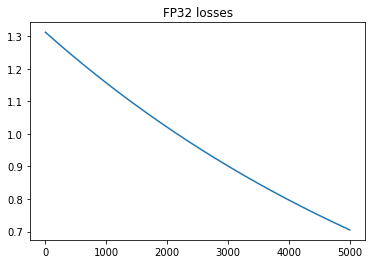

In [5]:
plt.figure()
plt.plot(np.array(fp32_losses))
plt.title('FP32 losses')
plt.show()

### Vanilla FP16 training
Alright, that was quite easy and nothing new so far.

Let's use FP16 now by calling `.half()` on the data, target as well as the model and run the training again.

In [6]:
x = x.half()
y = y.half()
model = nn.Linear(D_in, D_out).half().to(device)

fp16_state_dict = copy.deepcopy(model.state_dict())  # Save the state_dict for later! ;)

# Don't forget to recreate the optimizer for your new model!
optimizer = optim.SGD(model.parameters(), lr=1e-3)

Let's make sure the optimizer really stores out `torch.half` parameters and nothing goes wrong.

In [7]:
print(optimizer.param_groups[0]['params'][0])  # Print only first parameter

Parameter containing:
tensor([[-0.0020, -0.0127,  0.0111,  ...,  0.0179, -0.0020,  0.0007],
        [-0.0211, -0.0214, -0.0055,  ..., -0.0136,  0.0137,  0.0168],
        [-0.0303, -0.0004, -0.0237,  ...,  0.0228,  0.0233, -0.0044],
        ...,
        [ 0.0144,  0.0004,  0.0231,  ..., -0.0007, -0.0056,  0.0129],
        [-0.0051,  0.0192, -0.0273,  ..., -0.0134,  0.0158,  0.0272],
        [-0.0180, -0.0039, -0.0122,  ..., -0.0062,  0.0299, -0.0160]],
       device='cuda:0', dtype=torch.float16, requires_grad=True)


All set so let's train the model again.

In [8]:
fp16_losses = []
for t in range(5000):
    optimizer.zero_grad()
    
    output = model(x)
    loss = F.mse_loss(output, y)
    loss.backward()
    optimizer.step()

    fp16_losses.append(loss.item())

Iteration 0, loss 1.33203125
Iteration 1, loss 1.33203125
Iteration 2, loss 1.33203125
Iteration 3, loss 1.33203125
Iteration 4, loss 1.33203125
Iteration 5, loss 1.33203125
Iteration 6, loss 1.33203125
Iteration 7, loss 1.33203125
Iteration 8, loss 1.33203125
Iteration 9, loss 1.33203125
Iteration 10, loss 1.33203125
Iteration 11, loss 1.33203125
Iteration 12, loss 1.33203125
Iteration 13, loss 1.33203125
Iteration 14, loss 1.33203125
Iteration 15, loss 1.33203125
Iteration 16, loss 1.33203125
Iteration 17, loss 1.33203125
Iteration 18, loss 1.33203125
Iteration 19, loss 1.33203125
Iteration 20, loss 1.33203125
Iteration 21, loss 1.33203125
Iteration 22, loss 1.33203125
Iteration 23, loss 1.33203125
Iteration 24, loss 1.33203125
Iteration 25, loss 1.33203125
Iteration 26, loss 1.33203125
Iteration 27, loss 1.33203125
Iteration 28, loss 1.33203125
Iteration 29, loss 1.33203125
Iteration 30, loss 1.33203125
Iteration 31, loss 1.33203125
Iteration 32, loss 1.33203125
Iteration 33, loss 1

Iteration 385, loss 1.326171875
Iteration 386, loss 1.326171875
Iteration 387, loss 1.326171875
Iteration 388, loss 1.326171875
Iteration 389, loss 1.326171875
Iteration 390, loss 1.326171875
Iteration 391, loss 1.326171875
Iteration 392, loss 1.326171875
Iteration 393, loss 1.326171875
Iteration 394, loss 1.326171875
Iteration 395, loss 1.326171875
Iteration 396, loss 1.326171875
Iteration 397, loss 1.326171875
Iteration 398, loss 1.326171875
Iteration 399, loss 1.326171875
Iteration 400, loss 1.326171875
Iteration 401, loss 1.326171875
Iteration 402, loss 1.326171875
Iteration 403, loss 1.326171875
Iteration 404, loss 1.326171875
Iteration 405, loss 1.326171875
Iteration 406, loss 1.326171875
Iteration 407, loss 1.326171875
Iteration 408, loss 1.326171875
Iteration 409, loss 1.326171875
Iteration 410, loss 1.326171875
Iteration 411, loss 1.326171875
Iteration 412, loss 1.326171875
Iteration 413, loss 1.326171875
Iteration 414, loss 1.326171875
Iteration 415, loss 1.326171875
Iteratio

Iteration 791, loss 1.3212890625
Iteration 792, loss 1.3212890625
Iteration 793, loss 1.3203125
Iteration 794, loss 1.3203125
Iteration 795, loss 1.3203125
Iteration 796, loss 1.3203125
Iteration 797, loss 1.3203125
Iteration 798, loss 1.3203125
Iteration 799, loss 1.3203125
Iteration 800, loss 1.3203125
Iteration 801, loss 1.3203125
Iteration 802, loss 1.3203125
Iteration 803, loss 1.3203125
Iteration 804, loss 1.3203125
Iteration 805, loss 1.3203125
Iteration 806, loss 1.3203125
Iteration 807, loss 1.3203125
Iteration 808, loss 1.3203125
Iteration 809, loss 1.3203125
Iteration 810, loss 1.3203125
Iteration 811, loss 1.3203125
Iteration 812, loss 1.3203125
Iteration 813, loss 1.3203125
Iteration 814, loss 1.3203125
Iteration 815, loss 1.3203125
Iteration 816, loss 1.3203125
Iteration 817, loss 1.3203125
Iteration 818, loss 1.3203125
Iteration 819, loss 1.3203125
Iteration 820, loss 1.3203125
Iteration 821, loss 1.3203125
Iteration 822, loss 1.3203125
Iteration 823, loss 1.3203125
Iter

Iteration 1195, loss 1.31640625
Iteration 1196, loss 1.31640625
Iteration 1197, loss 1.31640625
Iteration 1198, loss 1.31640625
Iteration 1199, loss 1.31640625
Iteration 1200, loss 1.31640625
Iteration 1201, loss 1.31640625
Iteration 1202, loss 1.31640625
Iteration 1203, loss 1.31640625
Iteration 1204, loss 1.31640625
Iteration 1205, loss 1.31640625
Iteration 1206, loss 1.31640625
Iteration 1207, loss 1.31640625
Iteration 1208, loss 1.31640625
Iteration 1209, loss 1.31640625
Iteration 1210, loss 1.31640625
Iteration 1211, loss 1.31640625
Iteration 1212, loss 1.31640625
Iteration 1213, loss 1.31640625
Iteration 1214, loss 1.31640625
Iteration 1215, loss 1.31640625
Iteration 1216, loss 1.31640625
Iteration 1217, loss 1.31640625
Iteration 1218, loss 1.31640625
Iteration 1219, loss 1.31640625
Iteration 1220, loss 1.31640625
Iteration 1221, loss 1.31640625
Iteration 1222, loss 1.31640625
Iteration 1223, loss 1.31640625
Iteration 1224, loss 1.31640625
Iteration 1225, loss 1.31640625
Iteratio

Iteration 1591, loss 1.3125
Iteration 1592, loss 1.3125
Iteration 1593, loss 1.3125
Iteration 1594, loss 1.3125
Iteration 1595, loss 1.3125
Iteration 1596, loss 1.3125
Iteration 1597, loss 1.3125
Iteration 1598, loss 1.3125
Iteration 1599, loss 1.3125
Iteration 1600, loss 1.3125
Iteration 1601, loss 1.3125
Iteration 1602, loss 1.3125
Iteration 1603, loss 1.3125
Iteration 1604, loss 1.3125
Iteration 1605, loss 1.3125
Iteration 1606, loss 1.3125
Iteration 1607, loss 1.3125
Iteration 1608, loss 1.3125
Iteration 1609, loss 1.3125
Iteration 1610, loss 1.3125
Iteration 1611, loss 1.3125
Iteration 1612, loss 1.3125
Iteration 1613, loss 1.3125
Iteration 1614, loss 1.3125
Iteration 1615, loss 1.3125
Iteration 1616, loss 1.3125
Iteration 1617, loss 1.3125
Iteration 1618, loss 1.3125
Iteration 1619, loss 1.3125
Iteration 1620, loss 1.3125
Iteration 1621, loss 1.3125
Iteration 1622, loss 1.3125
Iteration 1623, loss 1.3125
Iteration 1624, loss 1.3125
Iteration 1625, loss 1.3125
Iteration 1626, loss

Iteration 1992, loss 1.30859375
Iteration 1993, loss 1.30859375
Iteration 1994, loss 1.30859375
Iteration 1995, loss 1.30859375
Iteration 1996, loss 1.30859375
Iteration 1997, loss 1.30859375
Iteration 1998, loss 1.30859375
Iteration 1999, loss 1.30859375
Iteration 2000, loss 1.30859375
Iteration 2001, loss 1.30859375
Iteration 2002, loss 1.30859375
Iteration 2003, loss 1.30859375
Iteration 2004, loss 1.30859375
Iteration 2005, loss 1.30859375
Iteration 2006, loss 1.30859375
Iteration 2007, loss 1.30859375
Iteration 2008, loss 1.30859375
Iteration 2009, loss 1.30859375
Iteration 2010, loss 1.30859375
Iteration 2011, loss 1.30859375
Iteration 2012, loss 1.30859375
Iteration 2013, loss 1.30859375
Iteration 2014, loss 1.30859375
Iteration 2015, loss 1.30859375
Iteration 2016, loss 1.30859375
Iteration 2017, loss 1.30859375
Iteration 2018, loss 1.30859375
Iteration 2019, loss 1.30859375
Iteration 2020, loss 1.30859375
Iteration 2021, loss 1.30859375
Iteration 2022, loss 1.30859375
Iteratio

Iteration 2381, loss 1.3056640625
Iteration 2382, loss 1.3056640625
Iteration 2383, loss 1.3056640625
Iteration 2384, loss 1.3056640625
Iteration 2385, loss 1.3056640625
Iteration 2386, loss 1.3056640625
Iteration 2387, loss 1.3056640625
Iteration 2388, loss 1.3056640625
Iteration 2389, loss 1.3056640625
Iteration 2390, loss 1.3056640625
Iteration 2391, loss 1.3056640625
Iteration 2392, loss 1.3056640625
Iteration 2393, loss 1.3056640625
Iteration 2394, loss 1.3056640625
Iteration 2395, loss 1.3056640625
Iteration 2396, loss 1.3056640625
Iteration 2397, loss 1.3056640625
Iteration 2398, loss 1.3056640625
Iteration 2399, loss 1.3056640625
Iteration 2400, loss 1.3056640625
Iteration 2401, loss 1.3056640625
Iteration 2402, loss 1.3056640625
Iteration 2403, loss 1.3056640625
Iteration 2404, loss 1.3056640625
Iteration 2405, loss 1.3056640625
Iteration 2406, loss 1.3056640625
Iteration 2407, loss 1.3056640625
Iteration 2408, loss 1.3056640625
Iteration 2409, loss 1.3056640625
Iteration 2410

Iteration 2776, loss 1.302734375
Iteration 2777, loss 1.302734375
Iteration 2778, loss 1.302734375
Iteration 2779, loss 1.302734375
Iteration 2780, loss 1.302734375
Iteration 2781, loss 1.302734375
Iteration 2782, loss 1.302734375
Iteration 2783, loss 1.302734375
Iteration 2784, loss 1.302734375
Iteration 2785, loss 1.302734375
Iteration 2786, loss 1.302734375
Iteration 2787, loss 1.302734375
Iteration 2788, loss 1.302734375
Iteration 2789, loss 1.302734375
Iteration 2790, loss 1.302734375
Iteration 2791, loss 1.302734375
Iteration 2792, loss 1.302734375
Iteration 2793, loss 1.302734375
Iteration 2794, loss 1.302734375
Iteration 2795, loss 1.302734375
Iteration 2796, loss 1.302734375
Iteration 2797, loss 1.302734375
Iteration 2798, loss 1.302734375
Iteration 2799, loss 1.302734375
Iteration 2800, loss 1.302734375
Iteration 2801, loss 1.302734375
Iteration 2802, loss 1.302734375
Iteration 2803, loss 1.302734375
Iteration 2804, loss 1.302734375
Iteration 2805, loss 1.302734375
Iteration 

Iteration 3185, loss 1.2998046875
Iteration 3186, loss 1.2998046875
Iteration 3187, loss 1.2998046875
Iteration 3188, loss 1.2998046875
Iteration 3189, loss 1.2998046875
Iteration 3190, loss 1.2998046875
Iteration 3191, loss 1.2998046875
Iteration 3192, loss 1.2998046875
Iteration 3193, loss 1.2998046875
Iteration 3194, loss 1.2998046875
Iteration 3195, loss 1.2998046875
Iteration 3196, loss 1.2998046875
Iteration 3197, loss 1.2998046875
Iteration 3198, loss 1.2998046875
Iteration 3199, loss 1.2998046875
Iteration 3200, loss 1.2998046875
Iteration 3201, loss 1.2998046875
Iteration 3202, loss 1.2998046875
Iteration 3203, loss 1.2998046875
Iteration 3204, loss 1.2998046875
Iteration 3205, loss 1.2998046875
Iteration 3206, loss 1.2998046875
Iteration 3207, loss 1.2998046875
Iteration 3208, loss 1.2998046875
Iteration 3209, loss 1.2998046875
Iteration 3210, loss 1.2998046875
Iteration 3211, loss 1.2998046875
Iteration 3212, loss 1.2998046875
Iteration 3213, loss 1.2998046875
Iteration 3214

Iteration 3635, loss 1.2978515625
Iteration 3636, loss 1.2978515625
Iteration 3637, loss 1.2978515625
Iteration 3638, loss 1.2978515625
Iteration 3639, loss 1.2978515625
Iteration 3640, loss 1.2978515625
Iteration 3641, loss 1.2978515625
Iteration 3642, loss 1.2978515625
Iteration 3643, loss 1.2978515625
Iteration 3644, loss 1.2978515625
Iteration 3645, loss 1.2978515625
Iteration 3646, loss 1.2978515625
Iteration 3647, loss 1.2978515625
Iteration 3648, loss 1.2978515625
Iteration 3649, loss 1.2978515625
Iteration 3650, loss 1.2978515625
Iteration 3651, loss 1.2978515625
Iteration 3652, loss 1.2978515625
Iteration 3653, loss 1.2978515625
Iteration 3654, loss 1.2978515625
Iteration 3655, loss 1.2978515625
Iteration 3656, loss 1.2978515625
Iteration 3657, loss 1.2978515625
Iteration 3658, loss 1.2978515625
Iteration 3659, loss 1.2978515625
Iteration 3660, loss 1.2978515625
Iteration 3661, loss 1.2978515625
Iteration 3662, loss 1.2978515625
Iteration 3663, loss 1.2978515625
Iteration 3664

Iteration 4048, loss 1.2958984375
Iteration 4049, loss 1.2958984375
Iteration 4050, loss 1.2958984375
Iteration 4051, loss 1.2958984375
Iteration 4052, loss 1.2958984375
Iteration 4053, loss 1.2958984375
Iteration 4054, loss 1.2958984375
Iteration 4055, loss 1.2958984375
Iteration 4056, loss 1.2958984375
Iteration 4057, loss 1.2958984375
Iteration 4058, loss 1.2958984375
Iteration 4059, loss 1.2958984375
Iteration 4060, loss 1.2958984375
Iteration 4061, loss 1.2958984375
Iteration 4062, loss 1.2958984375
Iteration 4063, loss 1.2958984375
Iteration 4064, loss 1.2958984375
Iteration 4065, loss 1.2958984375
Iteration 4066, loss 1.2958984375
Iteration 4067, loss 1.2958984375
Iteration 4068, loss 1.2958984375
Iteration 4069, loss 1.2958984375
Iteration 4070, loss 1.2958984375
Iteration 4071, loss 1.2958984375
Iteration 4072, loss 1.2958984375
Iteration 4073, loss 1.2958984375
Iteration 4074, loss 1.2958984375
Iteration 4075, loss 1.2958984375
Iteration 4076, loss 1.2958984375
Iteration 4077

Iteration 4482, loss 1.294921875
Iteration 4483, loss 1.294921875
Iteration 4484, loss 1.294921875
Iteration 4485, loss 1.294921875
Iteration 4486, loss 1.294921875
Iteration 4487, loss 1.294921875
Iteration 4488, loss 1.294921875
Iteration 4489, loss 1.294921875
Iteration 4490, loss 1.294921875
Iteration 4491, loss 1.294921875
Iteration 4492, loss 1.294921875
Iteration 4493, loss 1.294921875
Iteration 4494, loss 1.294921875
Iteration 4495, loss 1.294921875
Iteration 4496, loss 1.294921875
Iteration 4497, loss 1.294921875
Iteration 4498, loss 1.294921875
Iteration 4499, loss 1.294921875
Iteration 4500, loss 1.294921875
Iteration 4501, loss 1.294921875
Iteration 4502, loss 1.294921875
Iteration 4503, loss 1.294921875
Iteration 4504, loss 1.294921875
Iteration 4505, loss 1.294921875
Iteration 4506, loss 1.294921875
Iteration 4507, loss 1.294921875
Iteration 4508, loss 1.294921875
Iteration 4509, loss 1.294921875
Iteration 4510, loss 1.294921875
Iteration 4511, loss 1.294921875
Iteration 

Iteration 4913, loss 1.2939453125
Iteration 4914, loss 1.2939453125
Iteration 4915, loss 1.2939453125
Iteration 4916, loss 1.2939453125
Iteration 4917, loss 1.2939453125
Iteration 4918, loss 1.2939453125
Iteration 4919, loss 1.2939453125
Iteration 4920, loss 1.2939453125
Iteration 4921, loss 1.2939453125
Iteration 4922, loss 1.2939453125
Iteration 4923, loss 1.2939453125
Iteration 4924, loss 1.2939453125
Iteration 4925, loss 1.2939453125
Iteration 4926, loss 1.2939453125
Iteration 4927, loss 1.2939453125
Iteration 4928, loss 1.2939453125
Iteration 4929, loss 1.2939453125
Iteration 4930, loss 1.2939453125
Iteration 4931, loss 1.2939453125
Iteration 4932, loss 1.2939453125
Iteration 4933, loss 1.2939453125
Iteration 4934, loss 1.2939453125
Iteration 4935, loss 1.2939453125
Iteration 4936, loss 1.2939453125
Iteration 4937, loss 1.2939453125
Iteration 4938, loss 1.2939453125
Iteration 4939, loss 1.2939453125
Iteration 4940, loss 1.2939453125
Iteration 4941, loss 1.2939453125
Iteration 4942

Text(0.5,1,'FP16 losses')

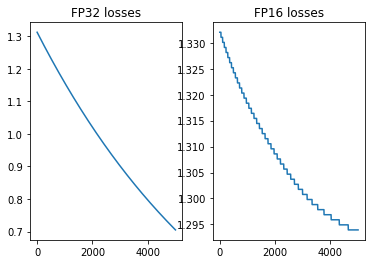

In [9]:
fig, axarr = plt.subplots(1, 2)
axarr[0].plot(np.array(fp32_losses))
axarr[0].set_title('FP32 losses')
axarr[1].plot(np.array(fp16_losses))
axarr[1].set_title('FP16 losses')

That doesn't seem to be right for the FP16 training.

The loss is not decreasing as in the FP32 case. Also note the steps in the loss curve.
Something might go wrong using FP16, so let's think about possible reasons for this strange behavior.

Maybe we are dealing with **imprecise weight updates** as descriped in the talk. This might be an issue if we are adding small gradients to larger weights. Let's see the example first.

In [10]:
param = torch.tensor([1.0], device=device, dtype=torch.float)
print(param + 0.0001)
param = torch.tensor([1.0], device=device, dtype=torch.half)
print(param + 0.0001)
print(torch.tensor([0.0001], device=device, dtype=torch.half))

tensor([1.0001], device='cuda:0')
tensor([1.], device='cuda:0', dtype=torch.float16)
tensor([0.0001], device='cuda:0', dtype=torch.float16)


Even though `1.0` as well as `0.0001` are representable using FP16, the addition loses entirely the weight update.

Fortunately we've saved the `state_dict` of your FP16 model, so that we can restore it and run some tests.

### FP32 Master Weights
The recipe given by Michael uses FP32 Master Weights to apply the gradient update. Here is the slide from the talk.

![master_weights](./images/master_weights.png)

Steps 1. and 2. are not changed in this approach. We are still dealing with out FP16 model and run a forward pass using our FP16 data. The backward call calculates also gradients for each parameter using FP16.

However, before the optimizer gets called to perform the weight updates, we copy all FP16 gradients to our FP32 Master Gradients, and apply the weight update on our FP32 Master Weights. 

Thereafter we just copy back the FP32 Master Weights to our model's FP16 weights and can perform another forward pass.
This approach makes sure our model stays in FP16 (with all possible performance benefits), while the sensitive gradient update step is performed in FP32.

There is still one thing missing. How can the optimizer update our FP32 Master Weights without any knowledge about these parameters? The vanilla approach is to pass the `model.parameters()` to the optimizer, so that it can update these.

Well, there is one trick we are using here, so let's have a look at some code and useful helper functions.

`apex.fp16_utils.prep_param_list` is a helper function to create FP32 master parameters for any model.
Here is a small extract of the source code (I've removed some optimized code, as it's not needed to understand the method).

```python
def prep_param_lists(model, flat_master=False):
    model_params = [param for param in model.parameters() if param.requires_grad]

    if flat_master:
        # ignore for now
    else:
        master_params = [param.clone().float().detach() for param in model_params]
        for param in master_params:
            param.requires_grad = True
        return model_params, master_params
```

First, we extract all model parameters which require gradients for easy copying the master parameters back to the model.
Using these parameters we create a copy of each parameter in FP32 and make sure to detach them from the computation graph. This makes sure that Autograd won't try to apply any gradient calculations on our master parameters when we call `backward` on the loss.

Let's try to implement this approach by restoring our old FP16 model and creating the FP32 master params.

In [11]:
from apex.fp16_utils import prep_param_lists, master_params_to_model_params, model_grads_to_master_grads

model.load_state_dict(fp16_state_dict)
model_params, master_params = prep_param_lists(model)

optimizer = optim.SGD(master_params, lr=1e-3)  # Pass master_params to optimizer!
print('Optimizer param[0]\n', optimizer.param_groups[0]['params'][0])  # Print only first parameter (Is now FP32)
print('Model weight\n', model.weight.data)

Optimizer param[0]
 tensor([[-0.0020, -0.0127,  0.0111,  ...,  0.0179, -0.0020,  0.0007],
        [-0.0211, -0.0214, -0.0055,  ..., -0.0136,  0.0137,  0.0168],
        [-0.0303, -0.0004, -0.0237,  ...,  0.0228,  0.0233, -0.0044],
        ...,
        [ 0.0144,  0.0004,  0.0231,  ..., -0.0007, -0.0056,  0.0129],
        [-0.0051,  0.0192, -0.0273,  ..., -0.0134,  0.0158,  0.0272],
        [-0.0180, -0.0039, -0.0122,  ..., -0.0062,  0.0299, -0.0160]],
       device='cuda:0', requires_grad=True)
Model weight
 tensor([[-0.0020, -0.0127,  0.0111,  ...,  0.0179, -0.0020,  0.0007],
        [-0.0211, -0.0214, -0.0055,  ..., -0.0136,  0.0137,  0.0168],
        [-0.0303, -0.0004, -0.0237,  ...,  0.0228,  0.0233, -0.0044],
        ...,
        [ 0.0144,  0.0004,  0.0231,  ..., -0.0007, -0.0056,  0.0129],
        [-0.0051,  0.0192, -0.0273,  ..., -0.0134,  0.0158,  0.0272],
        [-0.0180, -0.0039, -0.0122,  ..., -0.0062,  0.0299, -0.0160]],
       device='cuda:0', dtype=torch.float16)


As you can see, the optimizer indeed stores the FP32 copies of our original FP16 model parameters. Now let's implement all recipe shown in Michaels slide. Each step is described as a small comment in the code.

In [12]:
fp16_master_losses = []
for t in range(5000):
    model.zero_grad()  # Clear the model FP16 gradients, not the ones in optimizer!
    
    output = model(x)  # Step 1: Forward pass in FP16
    loss = F.mse_loss(output, y)
    loss.backward()  # Step 2: Compute backwards on FP16 model params
    model_grads_to_master_grads(model_params, master_params)  # Step3: Copy model FP16 gradients to master params
    optimizer.step()  # Step 4: Update master params
    master_params_to_model_params(model_params, master_params)  # Step 5: Copy master params back to model params

    fp16_master_losses.append(loss.item())

Iteration 0, loss 1.33203125
Iteration 1, loss 1.33203125
Iteration 2, loss 1.33203125
Iteration 3, loss 1.33203125
Iteration 4, loss 1.33203125
Iteration 5, loss 1.33203125
Iteration 6, loss 1.33203125
Iteration 7, loss 1.3310546875
Iteration 8, loss 1.3310546875
Iteration 9, loss 1.3310546875
Iteration 10, loss 1.3310546875
Iteration 11, loss 1.330078125
Iteration 12, loss 1.330078125
Iteration 13, loss 1.330078125
Iteration 14, loss 1.330078125
Iteration 15, loss 1.330078125
Iteration 16, loss 1.3291015625
Iteration 17, loss 1.3291015625
Iteration 18, loss 1.3291015625
Iteration 19, loss 1.3291015625
Iteration 20, loss 1.3291015625
Iteration 21, loss 1.3291015625
Iteration 22, loss 1.328125
Iteration 23, loss 1.328125
Iteration 24, loss 1.328125
Iteration 25, loss 1.328125
Iteration 26, loss 1.328125
Iteration 27, loss 1.328125
Iteration 28, loss 1.3271484375
Iteration 29, loss 1.3271484375
Iteration 30, loss 1.3271484375
Iteration 31, loss 1.3271484375
Iteration 32, loss 1.32714843

Iteration 371, loss 1.271484375
Iteration 372, loss 1.271484375
Iteration 373, loss 1.2705078125
Iteration 374, loss 1.2705078125
Iteration 375, loss 1.2705078125
Iteration 376, loss 1.2705078125
Iteration 377, loss 1.2705078125
Iteration 378, loss 1.2705078125
Iteration 379, loss 1.26953125
Iteration 380, loss 1.26953125
Iteration 381, loss 1.26953125
Iteration 382, loss 1.26953125
Iteration 383, loss 1.26953125
Iteration 384, loss 1.26953125
Iteration 385, loss 1.2685546875
Iteration 386, loss 1.2685546875
Iteration 387, loss 1.2685546875
Iteration 388, loss 1.2685546875
Iteration 389, loss 1.2685546875
Iteration 390, loss 1.2685546875
Iteration 391, loss 1.267578125
Iteration 392, loss 1.267578125
Iteration 393, loss 1.267578125
Iteration 394, loss 1.267578125
Iteration 395, loss 1.267578125
Iteration 396, loss 1.267578125
Iteration 397, loss 1.2666015625
Iteration 398, loss 1.2666015625
Iteration 399, loss 1.2666015625
Iteration 400, loss 1.2666015625
Iteration 401, loss 1.26660156

Iteration 799, loss 1.2041015625
Iteration 800, loss 1.2041015625
Iteration 801, loss 1.2041015625
Iteration 802, loss 1.2041015625
Iteration 803, loss 1.2041015625
Iteration 804, loss 1.2041015625
Iteration 805, loss 1.203125
Iteration 806, loss 1.203125
Iteration 807, loss 1.203125
Iteration 808, loss 1.203125
Iteration 809, loss 1.203125
Iteration 810, loss 1.203125
Iteration 811, loss 1.2021484375
Iteration 812, loss 1.2021484375
Iteration 813, loss 1.2021484375
Iteration 814, loss 1.2021484375
Iteration 815, loss 1.2021484375
Iteration 816, loss 1.2021484375
Iteration 817, loss 1.2021484375
Iteration 818, loss 1.201171875
Iteration 819, loss 1.201171875
Iteration 820, loss 1.201171875
Iteration 821, loss 1.201171875
Iteration 822, loss 1.201171875
Iteration 823, loss 1.201171875
Iteration 824, loss 1.2001953125
Iteration 825, loss 1.2001953125
Iteration 826, loss 1.2001953125
Iteration 827, loss 1.2001953125
Iteration 828, loss 1.2001953125
Iteration 829, loss 1.2001953125
Iterati

Iteration 1219, loss 1.142578125
Iteration 1220, loss 1.142578125
Iteration 1221, loss 1.142578125
Iteration 1222, loss 1.1416015625
Iteration 1223, loss 1.1416015625
Iteration 1224, loss 1.1416015625
Iteration 1225, loss 1.1416015625
Iteration 1226, loss 1.1416015625
Iteration 1227, loss 1.1416015625
Iteration 1228, loss 1.1416015625
Iteration 1229, loss 1.140625
Iteration 1230, loss 1.140625
Iteration 1231, loss 1.140625
Iteration 1232, loss 1.140625
Iteration 1233, loss 1.140625
Iteration 1234, loss 1.140625
Iteration 1235, loss 1.140625
Iteration 1236, loss 1.1396484375
Iteration 1237, loss 1.1396484375
Iteration 1238, loss 1.1396484375
Iteration 1239, loss 1.1396484375
Iteration 1240, loss 1.1396484375
Iteration 1241, loss 1.1396484375
Iteration 1242, loss 1.1396484375
Iteration 1243, loss 1.138671875
Iteration 1244, loss 1.138671875
Iteration 1245, loss 1.138671875
Iteration 1246, loss 1.138671875
Iteration 1247, loss 1.138671875
Iteration 1248, loss 1.138671875
Iteration 1249, l

Iteration 1618, loss 1.0869140625
Iteration 1619, loss 1.0869140625
Iteration 1620, loss 1.0869140625
Iteration 1621, loss 1.0859375
Iteration 1622, loss 1.0859375
Iteration 1623, loss 1.0859375
Iteration 1624, loss 1.0859375
Iteration 1625, loss 1.0859375
Iteration 1626, loss 1.0859375
Iteration 1627, loss 1.0859375
Iteration 1628, loss 1.0849609375
Iteration 1629, loss 1.0849609375
Iteration 1630, loss 1.0849609375
Iteration 1631, loss 1.0849609375
Iteration 1632, loss 1.0849609375
Iteration 1633, loss 1.0849609375
Iteration 1634, loss 1.0849609375
Iteration 1635, loss 1.083984375
Iteration 1636, loss 1.083984375
Iteration 1637, loss 1.083984375
Iteration 1638, loss 1.083984375
Iteration 1639, loss 1.083984375
Iteration 1640, loss 1.083984375
Iteration 1641, loss 1.083984375
Iteration 1642, loss 1.083984375
Iteration 1643, loss 1.0830078125
Iteration 1644, loss 1.0830078125
Iteration 1645, loss 1.0830078125
Iteration 1646, loss 1.0830078125
Iteration 1647, loss 1.0830078125
Iteration

Iteration 2022, loss 1.033203125
Iteration 2023, loss 1.033203125
Iteration 2024, loss 1.033203125
Iteration 2025, loss 1.033203125
Iteration 2026, loss 1.033203125
Iteration 2027, loss 1.0322265625
Iteration 2028, loss 1.0322265625
Iteration 2029, loss 1.0322265625
Iteration 2030, loss 1.0322265625
Iteration 2031, loss 1.0322265625
Iteration 2032, loss 1.0322265625
Iteration 2033, loss 1.0322265625
Iteration 2034, loss 1.0322265625
Iteration 2035, loss 1.03125
Iteration 2036, loss 1.03125
Iteration 2037, loss 1.03125
Iteration 2038, loss 1.03125
Iteration 2039, loss 1.03125
Iteration 2040, loss 1.03125
Iteration 2041, loss 1.03125
Iteration 2042, loss 1.0302734375
Iteration 2043, loss 1.0302734375
Iteration 2044, loss 1.0302734375
Iteration 2045, loss 1.0302734375
Iteration 2046, loss 1.0302734375
Iteration 2047, loss 1.0302734375
Iteration 2048, loss 1.0302734375
Iteration 2049, loss 1.0302734375
Iteration 2050, loss 1.029296875
Iteration 2051, loss 1.029296875
Iteration 2052, loss 1

Iteration 2431, loss 0.98193359375
Iteration 2432, loss 0.98193359375
Iteration 2433, loss 0.98193359375
Iteration 2434, loss 0.9814453125
Iteration 2435, loss 0.9814453125
Iteration 2436, loss 0.9814453125
Iteration 2437, loss 0.9814453125
Iteration 2438, loss 0.98095703125
Iteration 2439, loss 0.98095703125
Iteration 2440, loss 0.98095703125
Iteration 2441, loss 0.98095703125
Iteration 2442, loss 0.98046875
Iteration 2443, loss 0.98046875
Iteration 2444, loss 0.98046875
Iteration 2445, loss 0.98046875
Iteration 2446, loss 0.97998046875
Iteration 2447, loss 0.97998046875
Iteration 2448, loss 0.97998046875
Iteration 2449, loss 0.97998046875
Iteration 2450, loss 0.9794921875
Iteration 2451, loss 0.9794921875
Iteration 2452, loss 0.9794921875
Iteration 2453, loss 0.9794921875
Iteration 2454, loss 0.97900390625
Iteration 2455, loss 0.97900390625
Iteration 2456, loss 0.97900390625
Iteration 2457, loss 0.97900390625
Iteration 2458, loss 0.978515625
Iteration 2459, loss 0.978515625
Iteration

Iteration 2793, loss 0.93896484375
Iteration 2794, loss 0.93896484375
Iteration 2795, loss 0.9384765625
Iteration 2796, loss 0.9384765625
Iteration 2797, loss 0.9384765625
Iteration 2798, loss 0.9384765625
Iteration 2799, loss 0.93798828125
Iteration 2800, loss 0.93798828125
Iteration 2801, loss 0.93798828125
Iteration 2802, loss 0.93798828125
Iteration 2803, loss 0.9375
Iteration 2804, loss 0.9375
Iteration 2805, loss 0.9375
Iteration 2806, loss 0.9375
Iteration 2807, loss 0.93701171875
Iteration 2808, loss 0.93701171875
Iteration 2809, loss 0.93701171875
Iteration 2810, loss 0.93701171875
Iteration 2811, loss 0.93701171875
Iteration 2812, loss 0.9365234375
Iteration 2813, loss 0.9365234375
Iteration 2814, loss 0.9365234375
Iteration 2815, loss 0.9365234375
Iteration 2816, loss 0.93603515625
Iteration 2817, loss 0.93603515625
Iteration 2818, loss 0.93603515625
Iteration 2819, loss 0.93603515625
Iteration 2820, loss 0.935546875
Iteration 2821, loss 0.935546875
Iteration 2822, loss 0.93

Iteration 3194, loss 0.8935546875
Iteration 3195, loss 0.8935546875
Iteration 3196, loss 0.89306640625
Iteration 3197, loss 0.89306640625
Iteration 3198, loss 0.89306640625
Iteration 3199, loss 0.89306640625
Iteration 3200, loss 0.892578125
Iteration 3201, loss 0.892578125
Iteration 3202, loss 0.892578125
Iteration 3203, loss 0.892578125
Iteration 3204, loss 0.892578125
Iteration 3205, loss 0.89208984375
Iteration 3206, loss 0.89208984375
Iteration 3207, loss 0.89208984375
Iteration 3208, loss 0.89208984375
Iteration 3209, loss 0.8916015625
Iteration 3210, loss 0.8916015625
Iteration 3211, loss 0.8916015625
Iteration 3212, loss 0.8916015625
Iteration 3213, loss 0.89111328125
Iteration 3214, loss 0.89111328125
Iteration 3215, loss 0.89111328125
Iteration 3216, loss 0.89111328125
Iteration 3217, loss 0.89111328125
Iteration 3218, loss 0.890625
Iteration 3219, loss 0.890625
Iteration 3220, loss 0.890625
Iteration 3221, loss 0.890625
Iteration 3222, loss 0.89013671875
Iteration 3223, loss 

Iteration 3623, loss 0.84716796875
Iteration 3624, loss 0.84716796875
Iteration 3625, loss 0.84716796875
Iteration 3626, loss 0.84716796875
Iteration 3627, loss 0.84716796875
Iteration 3628, loss 0.8466796875
Iteration 3629, loss 0.8466796875
Iteration 3630, loss 0.8466796875
Iteration 3631, loss 0.8466796875
Iteration 3632, loss 0.8466796875
Iteration 3633, loss 0.84619140625
Iteration 3634, loss 0.84619140625
Iteration 3635, loss 0.84619140625
Iteration 3636, loss 0.84619140625
Iteration 3637, loss 0.84619140625
Iteration 3638, loss 0.845703125
Iteration 3639, loss 0.845703125
Iteration 3640, loss 0.845703125
Iteration 3641, loss 0.845703125
Iteration 3642, loss 0.84521484375
Iteration 3643, loss 0.84521484375
Iteration 3644, loss 0.84521484375
Iteration 3645, loss 0.84521484375
Iteration 3646, loss 0.84521484375
Iteration 3647, loss 0.8447265625
Iteration 3648, loss 0.8447265625
Iteration 3649, loss 0.8447265625
Iteration 3650, loss 0.8447265625
Iteration 3651, loss 0.8447265625
Ite

Iteration 4013, loss 0.8076171875
Iteration 4014, loss 0.8076171875
Iteration 4015, loss 0.8076171875
Iteration 4016, loss 0.8076171875
Iteration 4017, loss 0.80712890625
Iteration 4018, loss 0.80712890625
Iteration 4019, loss 0.80712890625
Iteration 4020, loss 0.80712890625
Iteration 4021, loss 0.80712890625
Iteration 4022, loss 0.806640625
Iteration 4023, loss 0.806640625
Iteration 4024, loss 0.806640625
Iteration 4025, loss 0.806640625
Iteration 4026, loss 0.806640625
Iteration 4027, loss 0.80615234375
Iteration 4028, loss 0.80615234375
Iteration 4029, loss 0.80615234375
Iteration 4030, loss 0.80615234375
Iteration 4031, loss 0.80615234375
Iteration 4032, loss 0.8056640625
Iteration 4033, loss 0.8056640625
Iteration 4034, loss 0.8056640625
Iteration 4035, loss 0.8056640625
Iteration 4036, loss 0.8056640625
Iteration 4037, loss 0.80517578125
Iteration 4038, loss 0.80517578125
Iteration 4039, loss 0.80517578125
Iteration 4040, loss 0.80517578125
Iteration 4041, loss 0.80517578125
Iter

Iteration 4426, loss 0.76806640625
Iteration 4427, loss 0.767578125
Iteration 4428, loss 0.767578125
Iteration 4429, loss 0.767578125
Iteration 4430, loss 0.767578125
Iteration 4431, loss 0.767578125
Iteration 4432, loss 0.76708984375
Iteration 4433, loss 0.76708984375
Iteration 4434, loss 0.76708984375
Iteration 4435, loss 0.76708984375
Iteration 4436, loss 0.76708984375
Iteration 4437, loss 0.76708984375
Iteration 4438, loss 0.7666015625
Iteration 4439, loss 0.7666015625
Iteration 4440, loss 0.7666015625
Iteration 4441, loss 0.7666015625
Iteration 4442, loss 0.7666015625
Iteration 4443, loss 0.76611328125
Iteration 4444, loss 0.76611328125
Iteration 4445, loss 0.76611328125
Iteration 4446, loss 0.76611328125
Iteration 4447, loss 0.76611328125
Iteration 4448, loss 0.765625
Iteration 4449, loss 0.765625
Iteration 4450, loss 0.765625
Iteration 4451, loss 0.765625
Iteration 4452, loss 0.765625
Iteration 4453, loss 0.76513671875
Iteration 4454, loss 0.76513671875
Iteration 4455, loss 0.76

Iteration 4825, loss 0.7314453125
Iteration 4826, loss 0.7314453125
Iteration 4827, loss 0.73095703125
Iteration 4828, loss 0.73095703125
Iteration 4829, loss 0.73095703125
Iteration 4830, loss 0.73095703125
Iteration 4831, loss 0.73095703125
Iteration 4832, loss 0.73095703125
Iteration 4833, loss 0.73046875
Iteration 4834, loss 0.73046875
Iteration 4835, loss 0.73046875
Iteration 4836, loss 0.73046875
Iteration 4837, loss 0.73046875
Iteration 4838, loss 0.72998046875
Iteration 4839, loss 0.72998046875
Iteration 4840, loss 0.72998046875
Iteration 4841, loss 0.72998046875
Iteration 4842, loss 0.72998046875
Iteration 4843, loss 0.72998046875
Iteration 4844, loss 0.7294921875
Iteration 4845, loss 0.7294921875
Iteration 4846, loss 0.7294921875
Iteration 4847, loss 0.7294921875
Iteration 4848, loss 0.7294921875
Iteration 4849, loss 0.72900390625
Iteration 4850, loss 0.72900390625
Iteration 4851, loss 0.72900390625
Iteration 4852, loss 0.72900390625
Iteration 4853, loss 0.72900390625
Iterati

Text(0.5,1,'FP16 (FP32 Master Params) losses')

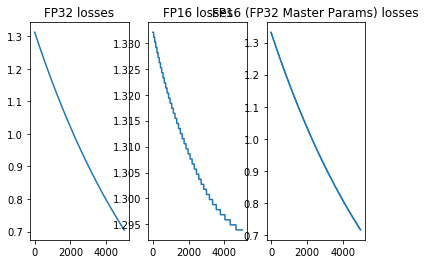

In [13]:
fig, axarr = plt.subplots(1, 3)
axarr[0].plot(np.array(fp32_losses))
axarr[0].set_title('FP32 losses')
axarr[1].plot(np.array(fp16_losses))
axarr[1].set_title('FP16 losses')
axarr[2].plot(np.array(fp16_master_losses))
axarr[2].set_title('FP16 (FP32 Master Params) losses')

Here we go! Now the FP16 loss curve using FP32 master params looks pretty much like the original FP32 one.

But wait a moment... Alright, we are using an FP16 model with all the potential benefits the apex team has mentioned, however we are storing copies of the weights and also are copying the gradients to our FP32 master gradients.

In face we are using more memory now than if we would just stick to using FP from the beginning. The model might be faster through, so are we just trading memory for compute?

Well, actually no. Remember that in a lot of model architectures (especially CNNs) the memory footprint of the intermediate actications is much larger than the actual parameters!

### Loss (Gradient) Scaling

The other challenge using FP16 is that the gradients might simply underflow, since the dynamic range of FP16 is much smaller that that of FP32. Our `loss.backward()` call would simply create gradients which are that small in magnitute that they are not representable anymore in FP16.

Fortunately, the apex team came up with another trick named Loss Scaling!

The basic idea is to try to use the dynamic range of FP16 better by scaling up the loss using some kind of factor **S**.
This factor might be a constant (usually in the power of 2) or might be determined dynamically.

Let's first recap the concept from the GTC talk:

**Loss Scaling**
  1. Multiply the loss by some constant S.
  2. Call `backward()` on scaled loss.
     By chain rule, gradients will also be scaled by S.
     This preserves small gradient values.
  3. Unscale gradients before update `step()`.

Note that selecting a scale factor will **not** affect your learning rate or any other hyperparameter. So you don't have to worry about it.
  
This seems pretty straightforward to implement in code. We'll be using again our FP32 Master Weight code to add loss scaling.

In [14]:
model.load_state_dict(fp16_state_dict)
model_params, master_params = prep_param_lists(model)

optimizer = optim.SGD(master_params, lr=1e-3)
scale_factor = 128.0

fp16_scaled_losses = []
for t in range(5000):
    model.zero_grad()
    
    output = model(x)
    loss = F.mse_loss(output, y)
    scaled_loss = scale_factor * loss.float()  # Scale up the loss
    scaled_loss.backward()  # Call backward on scaled_loss!
    model_grads_to_master_grads(model_params, master_params)
    
    # Descale the FP32 master gradients
    for param in master_params:
        param.grad.data.mul_(1./scale_factor)
    optimizer.step()
    master_params_to_model_params(model_params, master_params)

    fp16_scaled_losses.append(loss.item())

Iteration 0, loss 1.33203125
Iteration 1, loss 1.33203125
Iteration 2, loss 1.33203125
Iteration 3, loss 1.33203125
Iteration 4, loss 1.33203125
Iteration 5, loss 1.33203125
Iteration 6, loss 1.33203125
Iteration 7, loss 1.3310546875
Iteration 8, loss 1.3310546875
Iteration 9, loss 1.3310546875
Iteration 10, loss 1.3310546875
Iteration 11, loss 1.330078125
Iteration 12, loss 1.330078125
Iteration 13, loss 1.330078125
Iteration 14, loss 1.330078125
Iteration 15, loss 1.330078125
Iteration 16, loss 1.3291015625
Iteration 17, loss 1.3291015625
Iteration 18, loss 1.3291015625
Iteration 19, loss 1.3291015625
Iteration 20, loss 1.3291015625
Iteration 21, loss 1.3291015625
Iteration 22, loss 1.328125
Iteration 23, loss 1.328125
Iteration 24, loss 1.328125
Iteration 25, loss 1.328125
Iteration 26, loss 1.328125
Iteration 27, loss 1.328125
Iteration 28, loss 1.3271484375
Iteration 29, loss 1.3271484375
Iteration 30, loss 1.3271484375
Iteration 31, loss 1.3271484375
Iteration 32, loss 1.32714843

Iteration 347, loss 1.275390625
Iteration 348, loss 1.2744140625
Iteration 349, loss 1.2744140625
Iteration 350, loss 1.2744140625
Iteration 351, loss 1.2744140625
Iteration 352, loss 1.2744140625
Iteration 353, loss 1.2744140625
Iteration 354, loss 1.2734375
Iteration 355, loss 1.2734375
Iteration 356, loss 1.2734375
Iteration 357, loss 1.2734375
Iteration 358, loss 1.2734375
Iteration 359, loss 1.2734375
Iteration 360, loss 1.2734375
Iteration 361, loss 1.2724609375
Iteration 362, loss 1.2724609375
Iteration 363, loss 1.2724609375
Iteration 364, loss 1.2724609375
Iteration 365, loss 1.2724609375
Iteration 366, loss 1.2724609375
Iteration 367, loss 1.271484375
Iteration 368, loss 1.271484375
Iteration 369, loss 1.271484375
Iteration 370, loss 1.271484375
Iteration 371, loss 1.271484375
Iteration 372, loss 1.271484375
Iteration 373, loss 1.2705078125
Iteration 374, loss 1.2705078125
Iteration 375, loss 1.2705078125
Iteration 376, loss 1.2705078125
Iteration 377, loss 1.2705078125
Itera

Iteration 693, loss 1.220703125
Iteration 694, loss 1.220703125
Iteration 695, loss 1.220703125
Iteration 696, loss 1.2197265625
Iteration 697, loss 1.2197265625
Iteration 698, loss 1.2197265625
Iteration 699, loss 1.2197265625
Iteration 700, loss 1.2197265625
Iteration 701, loss 1.2197265625
Iteration 702, loss 1.21875
Iteration 703, loss 1.21875
Iteration 704, loss 1.21875
Iteration 705, loss 1.21875
Iteration 706, loss 1.21875
Iteration 707, loss 1.21875
Iteration 708, loss 1.21875
Iteration 709, loss 1.2177734375
Iteration 710, loss 1.2177734375
Iteration 711, loss 1.2177734375
Iteration 712, loss 1.2177734375
Iteration 713, loss 1.2177734375
Iteration 714, loss 1.2177734375
Iteration 715, loss 1.216796875
Iteration 716, loss 1.216796875
Iteration 717, loss 1.216796875
Iteration 718, loss 1.216796875
Iteration 719, loss 1.216796875
Iteration 720, loss 1.216796875
Iteration 721, loss 1.2158203125
Iteration 722, loss 1.2158203125
Iteration 723, loss 1.2158203125
Iteration 724, loss 1

Iteration 1059, loss 1.166015625
Iteration 1060, loss 1.1650390625
Iteration 1061, loss 1.1650390625
Iteration 1062, loss 1.1650390625
Iteration 1063, loss 1.1650390625
Iteration 1064, loss 1.1650390625
Iteration 1065, loss 1.1650390625
Iteration 1066, loss 1.1650390625
Iteration 1067, loss 1.1640625
Iteration 1068, loss 1.1640625
Iteration 1069, loss 1.1640625
Iteration 1070, loss 1.1640625
Iteration 1071, loss 1.1640625
Iteration 1072, loss 1.1640625
Iteration 1073, loss 1.1640625
Iteration 1074, loss 1.1630859375
Iteration 1075, loss 1.1630859375
Iteration 1076, loss 1.1630859375
Iteration 1077, loss 1.1630859375
Iteration 1078, loss 1.1630859375
Iteration 1079, loss 1.1630859375
Iteration 1080, loss 1.162109375
Iteration 1081, loss 1.162109375
Iteration 1082, loss 1.162109375
Iteration 1083, loss 1.162109375
Iteration 1084, loss 1.162109375
Iteration 1085, loss 1.162109375
Iteration 1086, loss 1.162109375
Iteration 1087, loss 1.1611328125
Iteration 1088, loss 1.1611328125
Iteration

Iteration 1406, loss 1.1162109375
Iteration 1407, loss 1.1162109375
Iteration 1408, loss 1.115234375
Iteration 1409, loss 1.115234375
Iteration 1410, loss 1.115234375
Iteration 1411, loss 1.115234375
Iteration 1412, loss 1.115234375
Iteration 1413, loss 1.115234375
Iteration 1414, loss 1.115234375
Iteration 1415, loss 1.1142578125
Iteration 1416, loss 1.1142578125
Iteration 1417, loss 1.1142578125
Iteration 1418, loss 1.1142578125
Iteration 1419, loss 1.1142578125
Iteration 1420, loss 1.1142578125
Iteration 1421, loss 1.1142578125
Iteration 1422, loss 1.11328125
Iteration 1423, loss 1.11328125
Iteration 1424, loss 1.11328125
Iteration 1425, loss 1.11328125
Iteration 1426, loss 1.11328125
Iteration 1427, loss 1.11328125
Iteration 1428, loss 1.11328125
Iteration 1429, loss 1.1123046875
Iteration 1430, loss 1.1123046875
Iteration 1431, loss 1.1123046875
Iteration 1432, loss 1.1123046875
Iteration 1433, loss 1.1123046875
Iteration 1434, loss 1.1123046875
Iteration 1435, loss 1.1123046875
I

Iteration 1771, loss 1.06640625
Iteration 1772, loss 1.06640625
Iteration 1773, loss 1.06640625
Iteration 1774, loss 1.0654296875
Iteration 1775, loss 1.0654296875
Iteration 1776, loss 1.0654296875
Iteration 1777, loss 1.0654296875
Iteration 1778, loss 1.0654296875
Iteration 1779, loss 1.0654296875
Iteration 1780, loss 1.0654296875
Iteration 1781, loss 1.064453125
Iteration 1782, loss 1.064453125
Iteration 1783, loss 1.064453125
Iteration 1784, loss 1.064453125
Iteration 1785, loss 1.064453125
Iteration 1786, loss 1.064453125
Iteration 1787, loss 1.064453125
Iteration 1788, loss 1.0634765625
Iteration 1789, loss 1.0634765625
Iteration 1790, loss 1.0634765625
Iteration 1791, loss 1.0634765625
Iteration 1792, loss 1.0634765625
Iteration 1793, loss 1.0634765625
Iteration 1794, loss 1.0634765625
Iteration 1795, loss 1.0634765625
Iteration 1796, loss 1.0625
Iteration 1797, loss 1.0625
Iteration 1798, loss 1.0625
Iteration 1799, loss 1.0625
Iteration 1800, loss 1.0625
Iteration 1801, loss 1.

Iteration 2147, loss 1.017578125
Iteration 2148, loss 1.017578125
Iteration 2149, loss 1.0166015625
Iteration 2150, loss 1.0166015625
Iteration 2151, loss 1.0166015625
Iteration 2152, loss 1.0166015625
Iteration 2153, loss 1.0166015625
Iteration 2154, loss 1.0166015625
Iteration 2155, loss 1.0166015625
Iteration 2156, loss 1.0166015625
Iteration 2157, loss 1.015625
Iteration 2158, loss 1.015625
Iteration 2159, loss 1.015625
Iteration 2160, loss 1.015625
Iteration 2161, loss 1.015625
Iteration 2162, loss 1.015625
Iteration 2163, loss 1.015625
Iteration 2164, loss 1.015625
Iteration 2165, loss 1.0146484375
Iteration 2166, loss 1.0146484375
Iteration 2167, loss 1.0146484375
Iteration 2168, loss 1.0146484375
Iteration 2169, loss 1.0146484375
Iteration 2170, loss 1.0146484375
Iteration 2171, loss 1.0146484375
Iteration 2172, loss 1.0146484375
Iteration 2173, loss 1.013671875
Iteration 2174, loss 1.013671875
Iteration 2175, loss 1.013671875
Iteration 2176, loss 1.013671875
Iteration 2177, lo

Iteration 2537, loss 0.96923828125
Iteration 2538, loss 0.96923828125
Iteration 2539, loss 0.96875
Iteration 2540, loss 0.96875
Iteration 2541, loss 0.96875
Iteration 2542, loss 0.96875
Iteration 2543, loss 0.96826171875
Iteration 2544, loss 0.96826171875
Iteration 2545, loss 0.96826171875
Iteration 2546, loss 0.96826171875
Iteration 2547, loss 0.9677734375
Iteration 2548, loss 0.9677734375
Iteration 2549, loss 0.9677734375
Iteration 2550, loss 0.9677734375
Iteration 2551, loss 0.96728515625
Iteration 2552, loss 0.96728515625
Iteration 2553, loss 0.96728515625
Iteration 2554, loss 0.96728515625
Iteration 2555, loss 0.966796875
Iteration 2556, loss 0.966796875
Iteration 2557, loss 0.966796875
Iteration 2558, loss 0.966796875
Iteration 2559, loss 0.96630859375
Iteration 2560, loss 0.96630859375
Iteration 2561, loss 0.96630859375
Iteration 2562, loss 0.96630859375
Iteration 2563, loss 0.9658203125
Iteration 2564, loss 0.9658203125
Iteration 2565, loss 0.9658203125
Iteration 2566, loss 0.9

Iteration 2893, loss 0.92724609375
Iteration 2894, loss 0.92724609375
Iteration 2895, loss 0.92724609375
Iteration 2896, loss 0.9267578125
Iteration 2897, loss 0.9267578125
Iteration 2898, loss 0.9267578125
Iteration 2899, loss 0.9267578125
Iteration 2900, loss 0.9267578125
Iteration 2901, loss 0.92626953125
Iteration 2902, loss 0.92626953125
Iteration 2903, loss 0.92626953125
Iteration 2904, loss 0.92626953125
Iteration 2905, loss 0.92578125
Iteration 2906, loss 0.92578125
Iteration 2907, loss 0.92578125
Iteration 2908, loss 0.92578125
Iteration 2909, loss 0.92529296875
Iteration 2910, loss 0.92529296875
Iteration 2911, loss 0.92529296875
Iteration 2912, loss 0.92529296875
Iteration 2913, loss 0.9248046875
Iteration 2914, loss 0.9248046875
Iteration 2915, loss 0.9248046875
Iteration 2916, loss 0.9248046875
Iteration 2917, loss 0.9248046875
Iteration 2918, loss 0.92431640625
Iteration 2919, loss 0.92431640625
Iteration 2920, loss 0.92431640625
Iteration 2921, loss 0.92431640625
Iterati

Iteration 3261, loss 0.88623046875
Iteration 3262, loss 0.8857421875
Iteration 3263, loss 0.8857421875
Iteration 3264, loss 0.8857421875
Iteration 3265, loss 0.8857421875
Iteration 3266, loss 0.8857421875
Iteration 3267, loss 0.88525390625
Iteration 3268, loss 0.88525390625
Iteration 3269, loss 0.88525390625
Iteration 3270, loss 0.88525390625
Iteration 3271, loss 0.884765625
Iteration 3272, loss 0.884765625
Iteration 3273, loss 0.884765625
Iteration 3274, loss 0.884765625
Iteration 3275, loss 0.884765625
Iteration 3276, loss 0.88427734375
Iteration 3277, loss 0.88427734375
Iteration 3278, loss 0.88427734375
Iteration 3279, loss 0.88427734375
Iteration 3280, loss 0.8837890625
Iteration 3281, loss 0.8837890625
Iteration 3282, loss 0.8837890625
Iteration 3283, loss 0.8837890625
Iteration 3284, loss 0.8837890625
Iteration 3285, loss 0.88330078125
Iteration 3286, loss 0.88330078125
Iteration 3287, loss 0.88330078125
Iteration 3288, loss 0.88330078125
Iteration 3289, loss 0.8828125
Iteration

Iteration 3647, loss 0.8447265625
Iteration 3648, loss 0.8447265625
Iteration 3649, loss 0.8447265625
Iteration 3650, loss 0.8447265625
Iteration 3651, loss 0.8447265625
Iteration 3652, loss 0.84423828125
Iteration 3653, loss 0.84423828125
Iteration 3654, loss 0.84423828125
Iteration 3655, loss 0.84423828125
Iteration 3656, loss 0.84375
Iteration 3657, loss 0.84375
Iteration 3658, loss 0.84375
Iteration 3659, loss 0.84375
Iteration 3660, loss 0.84375
Iteration 3661, loss 0.84326171875
Iteration 3662, loss 0.84326171875
Iteration 3663, loss 0.84326171875
Iteration 3664, loss 0.84326171875
Iteration 3665, loss 0.84326171875
Iteration 3666, loss 0.8427734375
Iteration 3667, loss 0.8427734375
Iteration 3668, loss 0.8427734375
Iteration 3669, loss 0.8427734375
Iteration 3670, loss 0.84228515625
Iteration 3671, loss 0.84228515625
Iteration 3672, loss 0.84228515625
Iteration 3673, loss 0.84228515625
Iteration 3674, loss 0.84228515625
Iteration 3675, loss 0.841796875
Iteration 3676, loss 0.841

Iteration 4031, loss 0.80615234375
Iteration 4032, loss 0.8056640625
Iteration 4033, loss 0.8056640625
Iteration 4034, loss 0.8056640625
Iteration 4035, loss 0.8056640625
Iteration 4036, loss 0.8056640625
Iteration 4037, loss 0.80517578125
Iteration 4038, loss 0.80517578125
Iteration 4039, loss 0.80517578125
Iteration 4040, loss 0.80517578125
Iteration 4041, loss 0.80517578125
Iteration 4042, loss 0.8046875
Iteration 4043, loss 0.8046875
Iteration 4044, loss 0.8046875
Iteration 4045, loss 0.8046875
Iteration 4046, loss 0.8046875
Iteration 4047, loss 0.80419921875
Iteration 4048, loss 0.80419921875
Iteration 4049, loss 0.80419921875
Iteration 4050, loss 0.80419921875
Iteration 4051, loss 0.80419921875
Iteration 4052, loss 0.8037109375
Iteration 4053, loss 0.8037109375
Iteration 4054, loss 0.8037109375
Iteration 4055, loss 0.8037109375
Iteration 4056, loss 0.8037109375
Iteration 4057, loss 0.80322265625
Iteration 4058, loss 0.80322265625
Iteration 4059, loss 0.80322265625
Iteration 4060,

Iteration 4400, loss 0.7705078125
Iteration 4401, loss 0.77001953125
Iteration 4402, loss 0.77001953125
Iteration 4403, loss 0.77001953125
Iteration 4404, loss 0.77001953125
Iteration 4405, loss 0.77001953125
Iteration 4406, loss 0.76953125
Iteration 4407, loss 0.76953125
Iteration 4408, loss 0.76953125
Iteration 4409, loss 0.76953125
Iteration 4410, loss 0.76953125
Iteration 4411, loss 0.76953125
Iteration 4412, loss 0.76904296875
Iteration 4413, loss 0.76904296875
Iteration 4414, loss 0.76904296875
Iteration 4415, loss 0.76904296875
Iteration 4416, loss 0.76904296875
Iteration 4417, loss 0.7685546875
Iteration 4418, loss 0.7685546875
Iteration 4419, loss 0.7685546875
Iteration 4420, loss 0.7685546875
Iteration 4421, loss 0.7685546875
Iteration 4422, loss 0.76806640625
Iteration 4423, loss 0.76806640625
Iteration 4424, loss 0.76806640625
Iteration 4425, loss 0.76806640625
Iteration 4426, loss 0.76806640625
Iteration 4427, loss 0.767578125
Iteration 4428, loss 0.767578125
Iteration 442

Iteration 4728, loss 0.740234375
Iteration 4729, loss 0.73974609375
Iteration 4730, loss 0.73974609375
Iteration 4731, loss 0.73974609375
Iteration 4732, loss 0.73974609375
Iteration 4733, loss 0.73974609375
Iteration 4734, loss 0.73974609375
Iteration 4735, loss 0.7392578125
Iteration 4736, loss 0.7392578125
Iteration 4737, loss 0.7392578125
Iteration 4738, loss 0.7392578125
Iteration 4739, loss 0.7392578125
Iteration 4740, loss 0.73876953125
Iteration 4741, loss 0.73876953125
Iteration 4742, loss 0.73876953125
Iteration 4743, loss 0.73876953125
Iteration 4744, loss 0.73876953125
Iteration 4745, loss 0.73876953125
Iteration 4746, loss 0.73828125
Iteration 4747, loss 0.73828125
Iteration 4748, loss 0.73828125
Iteration 4749, loss 0.73828125
Iteration 4750, loss 0.73828125
Iteration 4751, loss 0.73779296875
Iteration 4752, loss 0.73779296875
Iteration 4753, loss 0.73779296875
Iteration 4754, loss 0.73779296875
Iteration 4755, loss 0.73779296875
Iteration 4756, loss 0.7373046875
Iteratio

Text(0.5,1,'FP16 (Loss Scaling) losses')

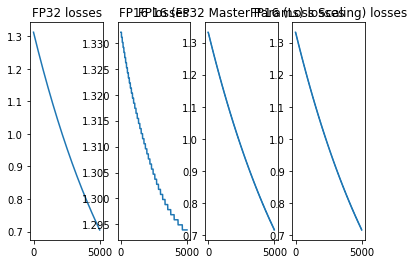

In [15]:
fig, axarr = plt.subplots(1, 4)
axarr[0].plot(np.array(fp32_losses))
axarr[0].set_title('FP32 losses')
axarr[1].plot(np.array(fp16_losses))
axarr[1].set_title('FP16 losses')
axarr[2].plot(np.array(fp16_master_losses))
axarr[2].set_title('FP16 (FP32 Master Params) losses')
axarr[3].plot(np.array(fp16_scaled_losses))
axarr[3].set_title('FP16 (Loss Scaling) losses')

You've might notices that we are transforming our `loss` to FP32 calling `loss.float()` before scaling it up.
This is just a small additional safety measure, since transforming a single scalar values won't influence the performance in any way. Also don't worry about our FP16 parameters or gradients being also converted to FP32. PyTorch's Autograd will capture this transform operation and makes sure to rewind this operation in the backward call.

Here is our new recipe taken from the GTC slides:

![loss_scaling_recipe](./images/loss_scaling.png)

Whew, this workflow looks a bit complicated now, right? Also, we are currently using a small dummy model and the code gets bigger and bigger. How would the code look like for a "real" model?

Well, don't worry about it! The apex team also provides some beautiful utilitity functions to make our life easier, but let's intriduce those methods a bit later.

At this point I would like to include a citation of Michael from his GTC talk:

_Honestly, we've really never met a network that we couldn't make this work for with careful selection of the loss scale._

That sounds promising! :)

### Dynamic Loss Scaling

It's often not clear which values to choose for the scaling factor. Even though a scaling factor of `128` seems to work quite good in a lot of use cases, you might want to use Dynamic Loss Scaling, to determing the factor.

Let's recap that loss scaling is used to prevent gradient **underflow** by scaling up the loss. Dynamic Loss Scaling prevents exactly this by using the highest loss scale that does not cause gradient **overflow**.

Here is the recipe for this util based on the GTC talk:

  1. Start with a large loss scale (e.g. 2**32)
  2. After each iteration, check if gradients overflowed (`Nan` or +/- `Inf`)
  3. If gradients overflowed, discard the iteration by skipping `optimizer.step()`
  4. If gradients overflowed, reduce [scaling factor] `S` for the next iteration (e.g. `S = S/2`)
  5. If `N` (e.g. 1000= iterations pass with no overflow, increase `S` again (`S = S*2`)
 
This workflow tries to use the highest loss scale that won't cause a gradient overflow and adapts the scale factor dynamically.

TODO: add example

### Accumulate in FP32

Sometimes reductions like `sum()` or `mean()` might overflow due to the limitations of FP16. To counter this effect, we should make sure to perform all sensitive reductions in FP32.

Let's use the example from Michael's GTC talk to see, what can go wrong.

In [16]:
a = torch.empty(4094, device=device, dtype=torch.half).fill_(16.0)
print(a.sum())
b = torch.empty(4095, device=device, dtype=torch.half).fill_(16.0)
print(b.sum())

tensor(65504., device='cuda:0', dtype=torch.float16)
tensor(inf, device='cuda:0', dtype=torch.float16)


As you can see we got an `Inf` in the second example, since we encoutered a value bigger than `65,504`. I believe we've all been there seeing our model outputting `Infs` or `NaNs` without any idea how to debug this issue and what could have gone wrong at all.

Using our previous example, we might get into trouble using our current criterion:
```python
loss = F.mse_loss(output, y)  # Both are FP16, thus might overflow!
```

Fortunately again, there is an easy fix for this!
We would just need to cast both values into FP32 so that the reduction won't overflow that easily.
```python
loss = F.mse_loss(output.float(), y.float())  # Won't overflow that easily!
```

Basically, we should be really careful using any reductions in FP16. An example of a typical layer using reductions is `nn.BatchNorm`.

To automatically convert all `nn.BatchNorm` layers in a model, apex provides this utility function, which recursively calls all child modules of our model and converts each BatchNorm to FP32.

```python
def BN_convert_float(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        BN_convert_float(child)
    return module
```

TODO: Based on this code, it's unclear to me, how the input to the FP32 BatchNorm layer will be transformed to a `FloatTensor`. I would expect to get a `RunTimeError`, but apparently the cast is automatically being performed (CUDA/C++/cuDNN backend?)

### FP16_Optimizer

As mentioned before, let's now have a look at the `FP16_Optimizer` and see, how the usage of this wrapper might simplify mixed precision training for us.

The `FP16_Optimizer` is an optimizer wrapper that automatically manages loss scaling and the FP32 Master Weights for us. It has some more features like an optionally automatic management of dynamic loss scaling, it's closure-safe (interesting for LBFGS), and compatible with PyTorch distributed training.

Let's rewrite our small example using this utility and compare both approaches.

Recall our manual approach:
```python
model_params, master_params = prep_param_lists(model)

optimizer = optim.SGD(master_params, lr=1e-3)
scale_factor = 128.0

for t in range(5000):
    model.zero_grad()  # Clear the model FP16 gradients, not the ones in optimizer!
    
    output = model(x)  # Forward pass in FP16
    loss = F.mse_loss(output, y)
    scaled_loss = scale_factor * loss.float()  # Scale up the loss
    scaled_loss.backward()  # Call backward on scaled_loss!
    model_grads_to_master_grads(model_params, master_params)  # Copy model FP16 gradients to master params
    
    # Descale the FP32 master gradients
    for param in master_params:
        param.grad.data.mul_(1./scale_factor)
    optimizer.step()  # Update master params
    master_params_to_model_params(model_params, master_params)  # Copy master params back to model params
    
    print('Iteration {}, loss {}'.format(
        t, loss.item()))
    ```

In [17]:
from apex.fp16_utils import FP16_Optimizer

# FP16_Optimizer
model.load_state_dict(fp16_state_dict)

optimizer = optim.SGD(model.parameters(), lr=1e-3)  # Pass FP16 model parameters to optimizer
scale_factor = 128.0
optimizer = FP16_Optimizer(optimizer, static_loss_scale=scale_factor)  # Pass original optimizer to FP16_optimizer

fp16_opt_losses = []
for t in range(5000):
    optimizer.zero_grad()
    
    output = model(x)  # Forward pass in FP16
    loss = F.mse_loss(output, y)
    
    # loss.backward() becomes:
    optimizer.backward(loss)  # Call backward on optimizer
    optimizer.step()
    
    fp16_opt_losses.append(loss.item())

FP16_Optimizer processing param group 0:
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512, 1024])
FP16_Optimizer received torch.cuda.HalfTensor with torch.Size([512])
Iteration 0, loss 1.33203125
Iteration 1, loss 1.33203125
Iteration 2, loss 1.33203125
Iteration 3, loss 1.33203125
Iteration 4, loss 1.33203125
Iteration 5, loss 1.33203125
Iteration 6, loss 1.33203125
Iteration 7, loss 1.3310546875
Iteration 8, loss 1.3310546875
Iteration 9, loss 1.3310546875
Iteration 10, loss 1.3310546875
Iteration 11, loss 1.330078125
Iteration 12, loss 1.330078125
Iteration 13, loss 1.330078125
Iteration 14, loss 1.330078125
Iteration 15, loss 1.330078125
Iteration 16, loss 1.3291015625
Iteration 17, loss 1.3291015625
Iteration 18, loss 1.3291015625
Iteration 19, loss 1.3291015625
Iteration 20, loss 1.3291015625
Iteration 21, loss 1.3291015625
Iteration 22, loss 1.328125
Iteration 23, loss 1.328125
Iteration 24, loss 1.328125
Iteration 25, loss 1.328125
Iteration 26, loss 1.328125


Iteration 313, loss 1.2802734375
Iteration 314, loss 1.2802734375
Iteration 315, loss 1.2802734375
Iteration 316, loss 1.2802734375
Iteration 317, loss 1.2802734375
Iteration 318, loss 1.279296875
Iteration 319, loss 1.279296875
Iteration 320, loss 1.279296875
Iteration 321, loss 1.279296875
Iteration 322, loss 1.279296875
Iteration 323, loss 1.279296875
Iteration 324, loss 1.2783203125
Iteration 325, loss 1.2783203125
Iteration 326, loss 1.2783203125
Iteration 327, loss 1.2783203125
Iteration 328, loss 1.2783203125
Iteration 329, loss 1.2783203125
Iteration 330, loss 1.27734375
Iteration 331, loss 1.27734375
Iteration 332, loss 1.27734375
Iteration 333, loss 1.27734375
Iteration 334, loss 1.27734375
Iteration 335, loss 1.27734375
Iteration 336, loss 1.2763671875
Iteration 337, loss 1.2763671875
Iteration 338, loss 1.2763671875
Iteration 339, loss 1.2763671875
Iteration 340, loss 1.2763671875
Iteration 341, loss 1.2763671875
Iteration 342, loss 1.275390625
Iteration 343, loss 1.2753906

Iteration 667, loss 1.224609375
Iteration 668, loss 1.224609375
Iteration 669, loss 1.224609375
Iteration 670, loss 1.224609375
Iteration 671, loss 1.2236328125
Iteration 672, loss 1.2236328125
Iteration 673, loss 1.2236328125
Iteration 674, loss 1.2236328125
Iteration 675, loss 1.2236328125
Iteration 676, loss 1.2236328125
Iteration 677, loss 1.22265625
Iteration 678, loss 1.22265625
Iteration 679, loss 1.22265625
Iteration 680, loss 1.22265625
Iteration 681, loss 1.22265625
Iteration 682, loss 1.22265625
Iteration 683, loss 1.2216796875
Iteration 684, loss 1.2216796875
Iteration 685, loss 1.2216796875
Iteration 686, loss 1.2216796875
Iteration 687, loss 1.2216796875
Iteration 688, loss 1.2216796875
Iteration 689, loss 1.2216796875
Iteration 690, loss 1.220703125
Iteration 691, loss 1.220703125
Iteration 692, loss 1.220703125
Iteration 693, loss 1.220703125
Iteration 694, loss 1.220703125
Iteration 695, loss 1.220703125
Iteration 696, loss 1.2197265625
Iteration 697, loss 1.2197265625

Iteration 1003, loss 1.173828125
Iteration 1004, loss 1.173828125
Iteration 1005, loss 1.173828125
Iteration 1006, loss 1.173828125
Iteration 1007, loss 1.1728515625
Iteration 1008, loss 1.1728515625
Iteration 1009, loss 1.1728515625
Iteration 1010, loss 1.1728515625
Iteration 1011, loss 1.1728515625
Iteration 1012, loss 1.1728515625
Iteration 1013, loss 1.1728515625
Iteration 1014, loss 1.171875
Iteration 1015, loss 1.171875
Iteration 1016, loss 1.171875
Iteration 1017, loss 1.171875
Iteration 1018, loss 1.171875
Iteration 1019, loss 1.171875
Iteration 1020, loss 1.1708984375
Iteration 1021, loss 1.1708984375
Iteration 1022, loss 1.1708984375
Iteration 1023, loss 1.1708984375
Iteration 1024, loss 1.1708984375
Iteration 1025, loss 1.1708984375
Iteration 1026, loss 1.1708984375
Iteration 1027, loss 1.169921875
Iteration 1028, loss 1.169921875
Iteration 1029, loss 1.169921875
Iteration 1030, loss 1.169921875
Iteration 1031, loss 1.169921875
Iteration 1032, loss 1.169921875
Iteration 1033

Iteration 1344, loss 1.125
Iteration 1345, loss 1.125
Iteration 1346, loss 1.1240234375
Iteration 1347, loss 1.1240234375
Iteration 1348, loss 1.1240234375
Iteration 1349, loss 1.1240234375
Iteration 1350, loss 1.1240234375
Iteration 1351, loss 1.1240234375
Iteration 1352, loss 1.1240234375
Iteration 1353, loss 1.123046875
Iteration 1354, loss 1.123046875
Iteration 1355, loss 1.123046875
Iteration 1356, loss 1.123046875
Iteration 1357, loss 1.123046875
Iteration 1358, loss 1.123046875
Iteration 1359, loss 1.123046875
Iteration 1360, loss 1.1220703125
Iteration 1361, loss 1.1220703125
Iteration 1362, loss 1.1220703125
Iteration 1363, loss 1.1220703125
Iteration 1364, loss 1.1220703125
Iteration 1365, loss 1.1220703125
Iteration 1366, loss 1.1220703125
Iteration 1367, loss 1.12109375
Iteration 1368, loss 1.12109375
Iteration 1369, loss 1.12109375
Iteration 1370, loss 1.12109375
Iteration 1371, loss 1.12109375
Iteration 1372, loss 1.12109375
Iteration 1373, loss 1.12109375
Iteration 1374,

Iteration 1682, loss 1.078125
Iteration 1683, loss 1.078125
Iteration 1684, loss 1.078125
Iteration 1685, loss 1.078125
Iteration 1686, loss 1.0771484375
Iteration 1687, loss 1.0771484375
Iteration 1688, loss 1.0771484375
Iteration 1689, loss 1.0771484375
Iteration 1690, loss 1.0771484375
Iteration 1691, loss 1.0771484375
Iteration 1692, loss 1.0771484375
Iteration 1693, loss 1.076171875
Iteration 1694, loss 1.076171875
Iteration 1695, loss 1.076171875
Iteration 1696, loss 1.076171875
Iteration 1697, loss 1.076171875
Iteration 1698, loss 1.076171875
Iteration 1699, loss 1.076171875
Iteration 1700, loss 1.076171875
Iteration 1701, loss 1.0751953125
Iteration 1702, loss 1.0751953125
Iteration 1703, loss 1.0751953125
Iteration 1704, loss 1.0751953125
Iteration 1705, loss 1.0751953125
Iteration 1706, loss 1.0751953125
Iteration 1707, loss 1.0751953125
Iteration 1708, loss 1.07421875
Iteration 1709, loss 1.07421875
Iteration 1710, loss 1.07421875
Iteration 1711, loss 1.07421875
Iteration 17

Iteration 2003, loss 1.0361328125
Iteration 2004, loss 1.03515625
Iteration 2005, loss 1.03515625
Iteration 2006, loss 1.03515625
Iteration 2007, loss 1.03515625
Iteration 2008, loss 1.03515625
Iteration 2009, loss 1.03515625
Iteration 2010, loss 1.03515625
Iteration 2011, loss 1.03515625
Iteration 2012, loss 1.0341796875
Iteration 2013, loss 1.0341796875
Iteration 2014, loss 1.0341796875
Iteration 2015, loss 1.0341796875
Iteration 2016, loss 1.0341796875
Iteration 2017, loss 1.0341796875
Iteration 2018, loss 1.0341796875
Iteration 2019, loss 1.0341796875
Iteration 2020, loss 1.033203125
Iteration 2021, loss 1.033203125
Iteration 2022, loss 1.033203125
Iteration 2023, loss 1.033203125
Iteration 2024, loss 1.033203125
Iteration 2025, loss 1.033203125
Iteration 2026, loss 1.033203125
Iteration 2027, loss 1.0322265625
Iteration 2028, loss 1.0322265625
Iteration 2029, loss 1.0322265625
Iteration 2030, loss 1.0322265625
Iteration 2031, loss 1.0322265625
Iteration 2032, loss 1.0322265625
Ite

Iteration 2325, loss 0.9951171875
Iteration 2326, loss 0.9951171875
Iteration 2327, loss 0.99462890625
Iteration 2328, loss 0.99462890625
Iteration 2329, loss 0.99462890625
Iteration 2330, loss 0.99462890625
Iteration 2331, loss 0.994140625
Iteration 2332, loss 0.994140625
Iteration 2333, loss 0.994140625
Iteration 2334, loss 0.994140625
Iteration 2335, loss 0.99365234375
Iteration 2336, loss 0.99365234375
Iteration 2337, loss 0.99365234375
Iteration 2338, loss 0.99365234375
Iteration 2339, loss 0.9931640625
Iteration 2340, loss 0.9931640625
Iteration 2341, loss 0.9931640625
Iteration 2342, loss 0.9931640625
Iteration 2343, loss 0.99267578125
Iteration 2344, loss 0.99267578125
Iteration 2345, loss 0.99267578125
Iteration 2346, loss 0.99267578125
Iteration 2347, loss 0.9921875
Iteration 2348, loss 0.9921875
Iteration 2349, loss 0.9921875
Iteration 2350, loss 0.9921875
Iteration 2351, loss 0.99169921875
Iteration 2352, loss 0.99169921875
Iteration 2353, loss 0.99169921875
Iteration 2354,

Iteration 2676, loss 0.95263671875
Iteration 2677, loss 0.95263671875
Iteration 2678, loss 0.9521484375
Iteration 2679, loss 0.9521484375
Iteration 2680, loss 0.9521484375
Iteration 2681, loss 0.9521484375
Iteration 2682, loss 0.95166015625
Iteration 2683, loss 0.95166015625
Iteration 2684, loss 0.95166015625
Iteration 2685, loss 0.95166015625
Iteration 2686, loss 0.95166015625
Iteration 2687, loss 0.951171875
Iteration 2688, loss 0.951171875
Iteration 2689, loss 0.951171875
Iteration 2690, loss 0.951171875
Iteration 2691, loss 0.95068359375
Iteration 2692, loss 0.95068359375
Iteration 2693, loss 0.95068359375
Iteration 2694, loss 0.95068359375
Iteration 2695, loss 0.9501953125
Iteration 2696, loss 0.9501953125
Iteration 2697, loss 0.9501953125
Iteration 2698, loss 0.9501953125
Iteration 2699, loss 0.94970703125
Iteration 2700, loss 0.94970703125
Iteration 2701, loss 0.94970703125
Iteration 2702, loss 0.94970703125
Iteration 2703, loss 0.94921875
Iteration 2704, loss 0.94921875
Iterati

Iteration 3006, loss 0.91455078125
Iteration 3007, loss 0.91455078125
Iteration 3008, loss 0.9140625
Iteration 3009, loss 0.9140625
Iteration 3010, loss 0.9140625
Iteration 3011, loss 0.9140625
Iteration 3012, loss 0.91357421875
Iteration 3013, loss 0.91357421875
Iteration 3014, loss 0.91357421875
Iteration 3015, loss 0.91357421875
Iteration 3016, loss 0.9130859375
Iteration 3017, loss 0.9130859375
Iteration 3018, loss 0.9130859375
Iteration 3019, loss 0.9130859375
Iteration 3020, loss 0.9130859375
Iteration 3021, loss 0.91259765625
Iteration 3022, loss 0.91259765625
Iteration 3023, loss 0.91259765625
Iteration 3024, loss 0.91259765625
Iteration 3025, loss 0.912109375
Iteration 3026, loss 0.912109375
Iteration 3027, loss 0.912109375
Iteration 3028, loss 0.912109375
Iteration 3029, loss 0.91162109375
Iteration 3030, loss 0.91162109375
Iteration 3031, loss 0.91162109375
Iteration 3032, loss 0.91162109375
Iteration 3033, loss 0.91162109375
Iteration 3034, loss 0.9111328125
Iteration 3035,

Iteration 3355, loss 0.8759765625
Iteration 3356, loss 0.8759765625
Iteration 3357, loss 0.87548828125
Iteration 3358, loss 0.87548828125
Iteration 3359, loss 0.87548828125
Iteration 3360, loss 0.87548828125
Iteration 3361, loss 0.875
Iteration 3362, loss 0.875
Iteration 3363, loss 0.875
Iteration 3364, loss 0.875
Iteration 3365, loss 0.875
Iteration 3366, loss 0.87451171875
Iteration 3367, loss 0.87451171875
Iteration 3368, loss 0.87451171875
Iteration 3369, loss 0.87451171875
Iteration 3370, loss 0.8740234375
Iteration 3371, loss 0.8740234375
Iteration 3372, loss 0.8740234375
Iteration 3373, loss 0.8740234375
Iteration 3374, loss 0.8740234375
Iteration 3375, loss 0.87353515625
Iteration 3376, loss 0.87353515625
Iteration 3377, loss 0.87353515625
Iteration 3378, loss 0.87353515625
Iteration 3379, loss 0.873046875
Iteration 3380, loss 0.873046875
Iteration 3381, loss 0.873046875
Iteration 3382, loss 0.873046875
Iteration 3383, loss 0.873046875
Iteration 3384, loss 0.87255859375
Iterati

Iteration 3698, loss 0.83984375
Iteration 3699, loss 0.83935546875
Iteration 3700, loss 0.83935546875
Iteration 3701, loss 0.83935546875
Iteration 3702, loss 0.83935546875
Iteration 3703, loss 0.8388671875
Iteration 3704, loss 0.8388671875
Iteration 3705, loss 0.8388671875
Iteration 3706, loss 0.8388671875
Iteration 3707, loss 0.8388671875
Iteration 3708, loss 0.83837890625
Iteration 3709, loss 0.83837890625
Iteration 3710, loss 0.83837890625
Iteration 3711, loss 0.83837890625
Iteration 3712, loss 0.83837890625
Iteration 3713, loss 0.837890625
Iteration 3714, loss 0.837890625
Iteration 3715, loss 0.837890625
Iteration 3716, loss 0.837890625
Iteration 3717, loss 0.837890625
Iteration 3718, loss 0.83740234375
Iteration 3719, loss 0.83740234375
Iteration 3720, loss 0.83740234375
Iteration 3721, loss 0.83740234375
Iteration 3722, loss 0.8369140625
Iteration 3723, loss 0.8369140625
Iteration 3724, loss 0.8369140625
Iteration 3725, loss 0.8369140625
Iteration 3726, loss 0.8369140625
Iteratio

Iteration 4022, loss 0.806640625
Iteration 4023, loss 0.806640625
Iteration 4024, loss 0.806640625
Iteration 4025, loss 0.806640625
Iteration 4026, loss 0.806640625
Iteration 4027, loss 0.80615234375
Iteration 4028, loss 0.80615234375
Iteration 4029, loss 0.80615234375
Iteration 4030, loss 0.80615234375
Iteration 4031, loss 0.80615234375
Iteration 4032, loss 0.8056640625
Iteration 4033, loss 0.8056640625
Iteration 4034, loss 0.8056640625
Iteration 4035, loss 0.8056640625
Iteration 4036, loss 0.8056640625
Iteration 4037, loss 0.80517578125
Iteration 4038, loss 0.80517578125
Iteration 4039, loss 0.80517578125
Iteration 4040, loss 0.80517578125
Iteration 4041, loss 0.80517578125
Iteration 4042, loss 0.8046875
Iteration 4043, loss 0.8046875
Iteration 4044, loss 0.8046875
Iteration 4045, loss 0.8046875
Iteration 4046, loss 0.8046875
Iteration 4047, loss 0.80419921875
Iteration 4048, loss 0.80419921875
Iteration 4049, loss 0.80419921875
Iteration 4050, loss 0.80419921875
Iteration 4051, loss

Iteration 4357, loss 0.7744140625
Iteration 4358, loss 0.7744140625
Iteration 4359, loss 0.7744140625
Iteration 4360, loss 0.77392578125
Iteration 4361, loss 0.77392578125
Iteration 4362, loss 0.77392578125
Iteration 4363, loss 0.77392578125
Iteration 4364, loss 0.77392578125
Iteration 4365, loss 0.7734375
Iteration 4366, loss 0.7734375
Iteration 4367, loss 0.7734375
Iteration 4368, loss 0.7734375
Iteration 4369, loss 0.7734375
Iteration 4370, loss 0.77294921875
Iteration 4371, loss 0.77294921875
Iteration 4372, loss 0.77294921875
Iteration 4373, loss 0.77294921875
Iteration 4374, loss 0.77294921875
Iteration 4375, loss 0.7724609375
Iteration 4376, loss 0.7724609375
Iteration 4377, loss 0.7724609375
Iteration 4378, loss 0.7724609375
Iteration 4379, loss 0.7724609375
Iteration 4380, loss 0.7724609375
Iteration 4381, loss 0.77197265625
Iteration 4382, loss 0.77197265625
Iteration 4383, loss 0.77197265625
Iteration 4384, loss 0.77197265625
Iteration 4385, loss 0.77197265625
Iteration 4386

Iteration 4680, loss 0.74462890625
Iteration 4681, loss 0.744140625
Iteration 4682, loss 0.744140625
Iteration 4683, loss 0.744140625
Iteration 4684, loss 0.744140625
Iteration 4685, loss 0.744140625
Iteration 4686, loss 0.74365234375
Iteration 4687, loss 0.74365234375
Iteration 4688, loss 0.74365234375
Iteration 4689, loss 0.74365234375
Iteration 4690, loss 0.74365234375
Iteration 4691, loss 0.74365234375
Iteration 4692, loss 0.7431640625
Iteration 4693, loss 0.7431640625
Iteration 4694, loss 0.7431640625
Iteration 4695, loss 0.7431640625
Iteration 4696, loss 0.7431640625
Iteration 4697, loss 0.74267578125
Iteration 4698, loss 0.74267578125
Iteration 4699, loss 0.74267578125
Iteration 4700, loss 0.74267578125
Iteration 4701, loss 0.74267578125
Iteration 4702, loss 0.7421875
Iteration 4703, loss 0.7421875
Iteration 4704, loss 0.7421875
Iteration 4705, loss 0.7421875
Iteration 4706, loss 0.7421875
Iteration 4707, loss 0.7421875
Iteration 4708, loss 0.74169921875
Iteration 4709, loss 0.7

Iteration 4987, loss 0.71728515625
Iteration 4988, loss 0.716796875
Iteration 4989, loss 0.716796875
Iteration 4990, loss 0.716796875
Iteration 4991, loss 0.716796875
Iteration 4992, loss 0.716796875
Iteration 4993, loss 0.71630859375
Iteration 4994, loss 0.71630859375
Iteration 4995, loss 0.71630859375
Iteration 4996, loss 0.71630859375
Iteration 4997, loss 0.71630859375
Iteration 4998, loss 0.71630859375
Iteration 4999, loss 0.7158203125


Text(0.5,1,'FP16_Opt losses')

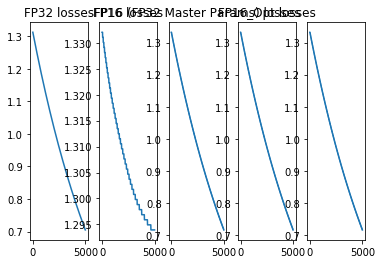

In [18]:
fig, axarr = plt.subplots(1, 5)
axarr[0].plot(np.array(fp32_losses))
axarr[0].set_title('FP32 losses')
axarr[1].plot(np.array(fp16_losses))
axarr[1].set_title('FP16 losses')
axarr[2].plot(np.array(fp16_master_losses))
axarr[2].set_title('FP16 (FP32 Master Params) losses')
axarr[3].plot(np.array(fp16_scaled_losses))
axarr[3].set_title('FP16 (Loss Scaling) losses')
axarr[4].plot(np.array(fp16_opt_losses))
axarr[3].set_title('FP16_Opt losses')

The interesting fact is that we just needed to change two lines of code compared to our vanilla PyTorch training procedure.

To be able to scale the loss and use FP32 Master Weights, the `FP1_Optimizer` takes the ownership of the backward pass now. Internally, references to the FP16 model parameters are stored in the instantiation step by passing the original optimizer (with references to the model parameters) to `FP16_Optimizer`. This also makes it possible to call `optimizer.zero_grad()` now instead of `model.zero_grad()` as in the manual FP16 training.

The most interesing part is the `backward()` call of the `FP16_Optimizer`, which basically performs all necessary steps for mixed precision training we were talking about before.
From the docs:
```
 1. fp32_loss = loss.float()
 2. scaled_loss = fp32_loss*loss_scale
 3. scaled_loss.backward(), which accumulates scaled gradients into the `.grad` attributes of the model's leaves.
 4. fp16 grads are then copied to the master params' `.grad` attributes, which are guaranteed to be fp32.
 5. Finally, master grads are divided by loss_scale.
```